In [1]:
# ===================== CELDA 0: CONFIG GLOBAL =====================
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import joblib

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

warnings.filterwarnings("ignore", category=FutureWarning)

# ---- PATH DEL EXPERIMENTO A ANALIZAR ----
RESULTS_DIR = Path("/home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25")
N_FOLDS = 5
TARGET_CLF = "logreg"  # cambia a "logreg", "svm", etc. si querés

print(f"[INFO] Analizando experimento en:\n{RESULTS_DIR.resolve()}")

# ---- ESTILO FIGURAS “Q1” ----
plt.style.use("default")
sns.set_style("white")

mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.dpi": 300,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# Carpeta para figuras/tablas de este experimento
OUTPUT_FIG_DIR = RESULTS_DIR / "training_qc"
OUTPUT_FIG_DIR.mkdir(exist_ok=True)
print(f"[INFO] Figuras/tablas se guardarán en: {OUTPUT_FIG_DIR}")


[INFO] Analizando experimento en:
/home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25
[INFO] Figuras/tablas se guardarán en: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/training_qc


In [2]:
# ===================== CELDA 1: CARGA DE ARTEFACTOS =====================
# 1) Métricas agregadas por fold
metrics_path = next(RESULTS_DIR.glob("all_folds_metrics_MULTI_*.csv"))
metrics_df = pd.read_csv(metrics_path)
print(f"[OK] Métricas CV cargadas desde:\n{metrics_path.name}")

# 2) Historias de entrenamiento del VAE
try:
    vae_hist_path = next(RESULTS_DIR.glob("all_folds_vae_training_history_*.joblib"))
    vae_histories = joblib.load(vae_hist_path)
    print(f"[OK] Historias VAE cargadas ({len(vae_histories)} folds) desde:\n{vae_hist_path.name}")
except StopIteration:
    vae_histories = None
    print("[WARN] No se encontró all_folds_vae_training_history_*.joblib")

# 3) QC latente y Fuga de Manufacturer (outputs de analysis_qc.py + latent_qc_metrics.py)
qc_latent_list = []
leak_train_list = []
dist_raw_list, dist_norm_list, dist_recon_list = [], [], []

for k in range(1, N_FOLDS + 1):
    fold_dir = RESULTS_DIR / f"fold_{k}"

    # --- QC latente por fold ---
    qc_path = fold_dir / "latent_qc_metrics.csv"
    if qc_path.exists():
        df_qc = pd.read_csv(qc_path)
        if "fold" not in df_qc.columns:
            df_qc["fold"] = k
        qc_latent_list.append(df_qc)
    else:
        print(f"[WARN] No se encontró {qc_path.name} en fold_{k}")

    # --- Fuga de Manufacturer (LogReg multi-clase) ---
    leak_path = fold_dir / f"fold_{k}_scanner_leakage.csv"
    if leak_path.exists():
        df_leak = pd.read_csv(leak_path)
        df_leak["fold"] = k
        leak_train_list.append(df_leak)
    else:
        print(f"[WARN] No se encontró {leak_path.name}")

    # --- Stats de distribuciones (raw / norm / recon) ---
    for stage, store in [("raw", dist_raw_list),
                         ("norm", dist_norm_list),
                         ("recon", dist_recon_list)]:
        dist_path = fold_dir / f"fold_{k}_dist_{stage}.csv"
        if dist_path.exists():
            df_dist = pd.read_csv(dist_path)
            df_dist["fold"] = k
            store.append(df_dist)

qc_latent = pd.concat(qc_latent_list, ignore_index=True) if qc_latent_list else None
leak_train = pd.concat(leak_train_list, ignore_index=True) if leak_train_list else None
dist_raw_all = pd.concat(dist_raw_list, ignore_index=True) if dist_raw_list else None
dist_norm_all = pd.concat(dist_norm_list, ignore_index=True) if dist_norm_list else None
dist_recon_all = pd.concat(dist_recon_list, ignore_index=True) if dist_recon_list else None

print("\n[RESUMEN]")
print("  QC latente:", None if qc_latent is None else qc_latent.shape)
print("  Leakage train:", None if leak_train is None else leak_train.shape)
print("  Dist raw:", None if dist_raw_all is None else dist_raw_all.shape)
print("  Dist norm:", None if dist_norm_all is None else dist_norm_all.shape)
print("  Dist recon:", None if dist_recon_all is None else dist_recon_all.shape)


[OK] Métricas CV cargadas desde:
all_folds_metrics_MULTI_xgb_vaeconvtranspose4l_ld256_beta2.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.2_ln0_outer5x1_scoreroc_auc.csv
[OK] Historias VAE cargadas (5 folds) desde:
all_folds_vae_training_history_xgb_vaeconvtranspose4l_ld256_beta2.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.2_ln0_outer5x1_scoreroc_auc.joblib

[RESUMEN]
  QC latente: (5, 12)
  Leakage train: (10, 7)
  Dist raw: (15, 17)
  Dist norm: (15, 17)
  Dist recon: (15, 18)


In [3]:
# ===================== CELDA 2: TABLA MAESTRA POR FOLD =====================
# nos quedamos con el clasificador objetivo
m_clf = metrics_df[metrics_df["actual_classifier_type"] == TARGET_CLF].copy()
if m_clf.empty:
    raise ValueError(f"No hay filas para actual_classifier_type == '{TARGET_CLF}'")

# --- pivot de leakage (LogReg sitio) ---
if leak_train is not None:
    leak_pivot = (
        leak_train
        .pivot_table(index="fold",
                     columns="representation",
                     values="balanced_accuracy_mean")
        .rename(columns={
            "connectome_norm": "BA_Manufacturer_connectome_norm",
            "latent_mu": "BA_Manufacturer_latent_mu"
        })
        .reset_index()
    )
    # chance: 1 / n_clases por fold
    chance_manufacturer = (
        leak_train.groupby("fold")["n_classes"]
        .first()
        .rdiv(1.0)
        .reset_index()
        .rename(columns={"n_classes": "BA_Manufacturer_chance"})
    )
    leak_summary = leak_pivot.merge(chance_manufacturer, on="fold", how="left")
else:
    leak_summary = pd.DataFrame()

# --- merge métricas + QC latente + leakage ---
df_summary = m_clf.merge(qc_latent, on="fold", how="left", suffixes=("","_latentqc"))
if not leak_summary.empty:
    df_summary = df_summary.merge(leak_summary, on="fold", how="left")

# métricas derivadas
if "acc_manufacturer_latent" in df_summary.columns and "chance_level" in df_summary.columns:
    df_summary["Delta_manufacturer_latent_knn"] = df_summary["acc_manufacturer_latent"] - df_summary["chance_level"]
    df_summary["Delta_manufacturer_raw_knn"]    = df_summary["acc_manufacturer_raw"] - df_summary["chance_level"]

if "BA_Manufacturer_latent_mu" in df_summary.columns and "BA_Manufacturer_chance" in df_summary.columns:
    df_summary["Delta_manufacturer_latent_logreg"] = df_summary["BA_Manufacturer_latent_mu"] - df_summary["BA_Manufacturer_chance"]
    df_summary["Delta_manufacturer_conn_logreg"]   = df_summary["BA_Manufacturer_connectome_norm"] - df_summary["BA_Manufacturer_chance"]

cols_show = [
    "fold", "auc", "balanced_accuracy",
    "silhouette_latent",
    "acc_manufacturer_latent", "acc_manufacturer_raw", "chance_level",
    "BA_Manufacturer_connectome_norm", "BA_Manufacturer_latent_mu", "BA_Manufacturer_chance",
    "Delta_manufacturer_latent_knn", "Delta_manufacturer_latent_logreg"
]
cols_show = [c for c in cols_show if c in df_summary.columns]

display(df_summary[cols_show].round(4))

# guardamos para el paper
csv_path = OUTPUT_FIG_DIR / "table_training_qc_summary.csv"
tex_path = OUTPUT_FIG_DIR / "table_training_qc_summary.tex"

df_summary_round = df_summary.copy()
for c in df_summary_round.columns:
    if df_summary_round[c].dtype.kind in "fc":
        df_summary_round[c] = df_summary_round[c].round(3)

df_summary_round.to_csv(csv_path, index=False)
with open(tex_path, "w") as f:
    f.write(df_summary_round[cols_show].to_latex(index=False, escape=False, column_format="ccccccccccc"))

print(f"[OK] Tabla maestra guardada en:\n  {csv_path}\n  {tex_path}")


,fold,auc,balanced_accuracy,silhouette_latent,chance_level,BA_Manufacturer_connectome_norm,BA_Manufacturer_latent_mu,BA_Manufacturer_chance,Delta_manufacturer_latent_logreg
0,1,0.7895,0.7558,0.0185,0.3333,0.7038,0.6848,0.3333,0.3514
1,2,0.7602,0.7310,0.0019,0.3333,0.6916,0.8049,0.3333,0.4716
2,3,0.9327,0.8640,0.0351,0.3333,0.7365,0.7561,0.3333,0.4227
3,4,0.8567,0.8070,0.0070,0.3333,0.6749,0.7520,0.3333,0.4187
4,5,0.8762,0.7833,0.0173,0.3333,0.5813,0.6770,0.3333,0.3436


[OK] Tabla maestra guardada en:
  /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/training_qc/table_training_qc_summary.csv
  /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/training_qc/table_training_qc_summary.tex


In [4]:
# === Resumen global (media ± SD) para el paper ===
cols_to_agg = [
    "auc",
    "balanced_accuracy",
    "silhouette_latent",
    "Delta_manufacturer_latent_knn",
    "Delta_manufacturer_latent_logreg"
]
cols_to_agg = [c for c in cols_to_agg if c in df_summary.columns]

summary_stats = df_summary[cols_to_agg].agg(["mean", "std"]).T
summary_stats = summary_stats.rename(columns={"mean": "mean", "std": "sd"})
display(summary_stats.round(3))

# opcional: export a LaTeX
with open(OUTPUT_FIG_DIR / "table_training_qc_summary_global.tex", "w") as f:
    f.write(summary_stats.round(3).to_latex(escape=False, column_format="lcc"))


,mean,sd
auc,0.843,0.069
balanced_accuracy,0.788,0.051
silhouette_latent,0.016,0.013
Delta_manufacturer_latent_logreg,0.402,0.054



--- Correlaciones (Spearman) ---
Spearman(Silhouette, AUC) = 0.700, p = 0.188
Spearman(manufacturer BA (latent, LogReg), AUC) = -0.300, p = 0.624


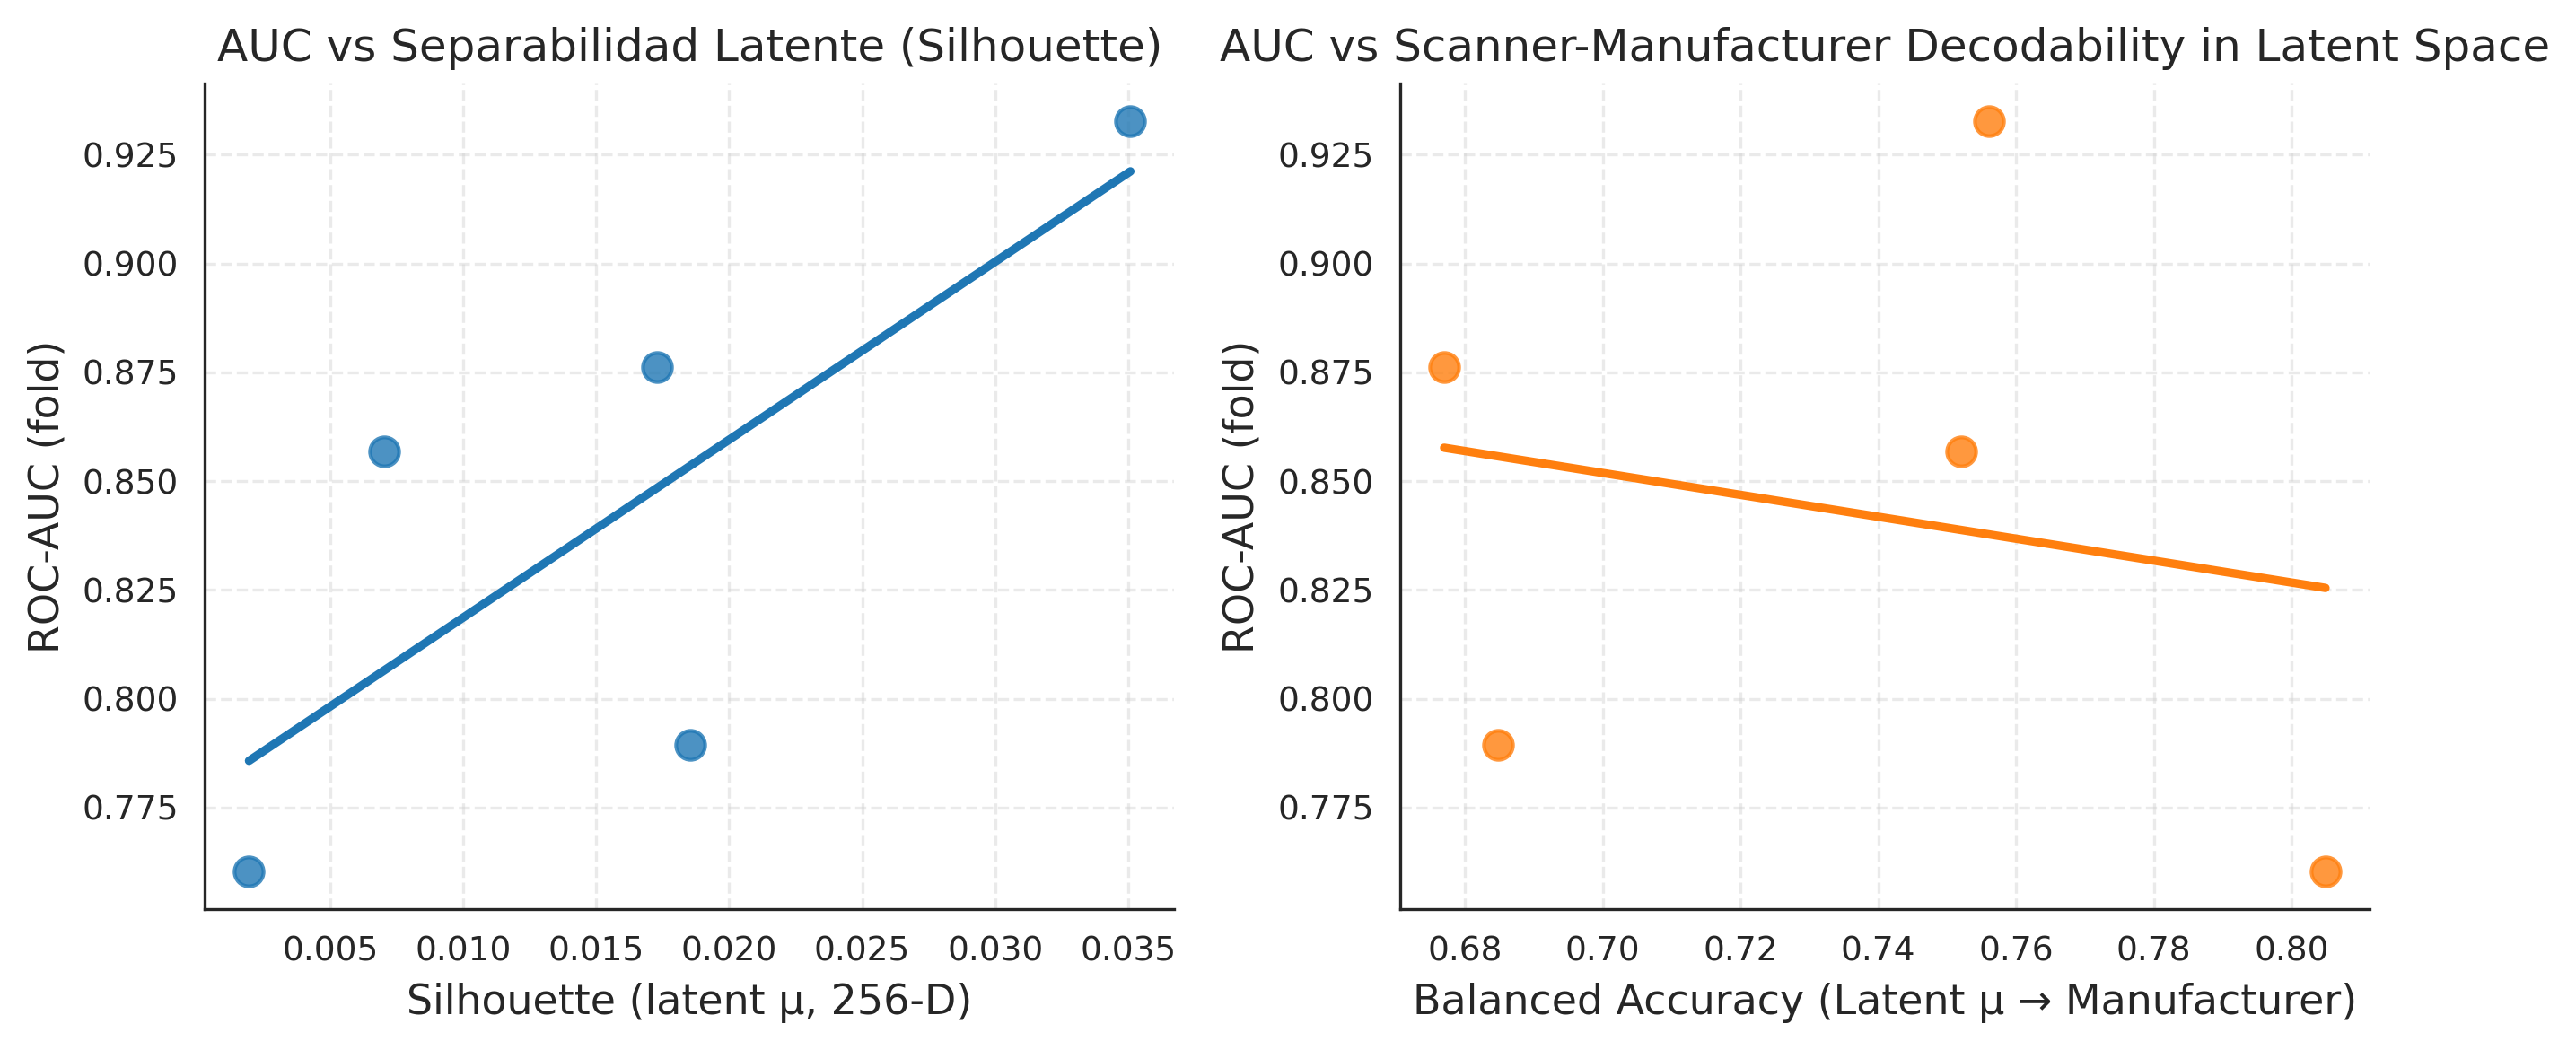

[OK] Figura AUC vs QC latente guardada.


In [5]:
# ===================== CELDA 3: CORRELACIONES AUC vs QC =====================
df_plot = df_summary.dropna(subset=["auc", "silhouette_latent"]).copy()

# correlaciones de Spearman (N=5 → interpretarlas con cautela)
def corr_and_print(x, y, label_x, label_y):
    r, p = spearmanr(x, y)
    print(f"Spearman({label_x}, {label_y}) = {r:.3f}, p = {p:.3f}")
    return r, p

print("\n--- Correlaciones (Spearman) ---")
corr_and_print(df_plot["silhouette_latent"], df_plot["auc"],
               "Silhouette", "AUC")

if "BA_Manufacturer_latent_mu" in df_plot.columns:
    corr_and_print(df_plot["BA_Manufacturer_latent_mu"], df_plot["auc"],
                   "manufacturer BA (latent, LogReg)", "AUC")

if "acc_manufacturer_latent" in df_plot.columns:
    corr_and_print(df_plot["acc_manufacturer_latent"], df_plot["auc"],
                   "Manufacturer acc (latent, kNN)", "AUC")

# --- Figura: AUC vs Silhouette y AUC vs fuga de sitio latente ---
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# A) AUC vs Silhouette
sns.regplot(data=df_plot, x="silhouette_latent", y="auc",
            ax=axes[0], ci=None, scatter_kws={"s":60})
axes[0].set_title("AUC vs Separabilidad Latente (Silhouette)")
axes[0].set_xlabel("Silhouette (latent μ, 256-D)")
axes[0].set_ylabel("ROC-AUC (fold)")
axes[0].grid(True, linestyle="--", alpha=0.4)

# B) AUC vs Fuga de Manufacturer en latente (LogReg)
if "BA_Manufacturer_latent_mu" in df_plot.columns:
    sns.regplot(data=df_plot, x="BA_Manufacturer_latent_mu", y="auc",
                ax=axes[1], ci=None, scatter_kws={"s":60}, color="tab:orange")
    axes[1].set_title("AUC vs Scanner-Manufacturer Decodability in Latent Space")
    axes[1].set_xlabel("Balanced Accuracy (Latent μ → Manufacturer)")
    axes[1].set_ylabel("ROC-AUC (fold)")
    axes[1].grid(True, linestyle="--", alpha=0.4)
else:
    axes[1].axis("off")

fig.tight_layout()
fig.savefig(OUTPUT_FIG_DIR / "figure_auc_vs_qc_latent.pdf", bbox_inches="tight")
fig.savefig(OUTPUT_FIG_DIR / "figure_auc_vs_qc_latent.png", dpi=300, bbox_inches="tight")

plt.show()
print("[OK] Figura AUC vs QC latente guardada.")


Ploteando dinámica VAE para folds: best=3, worst=2


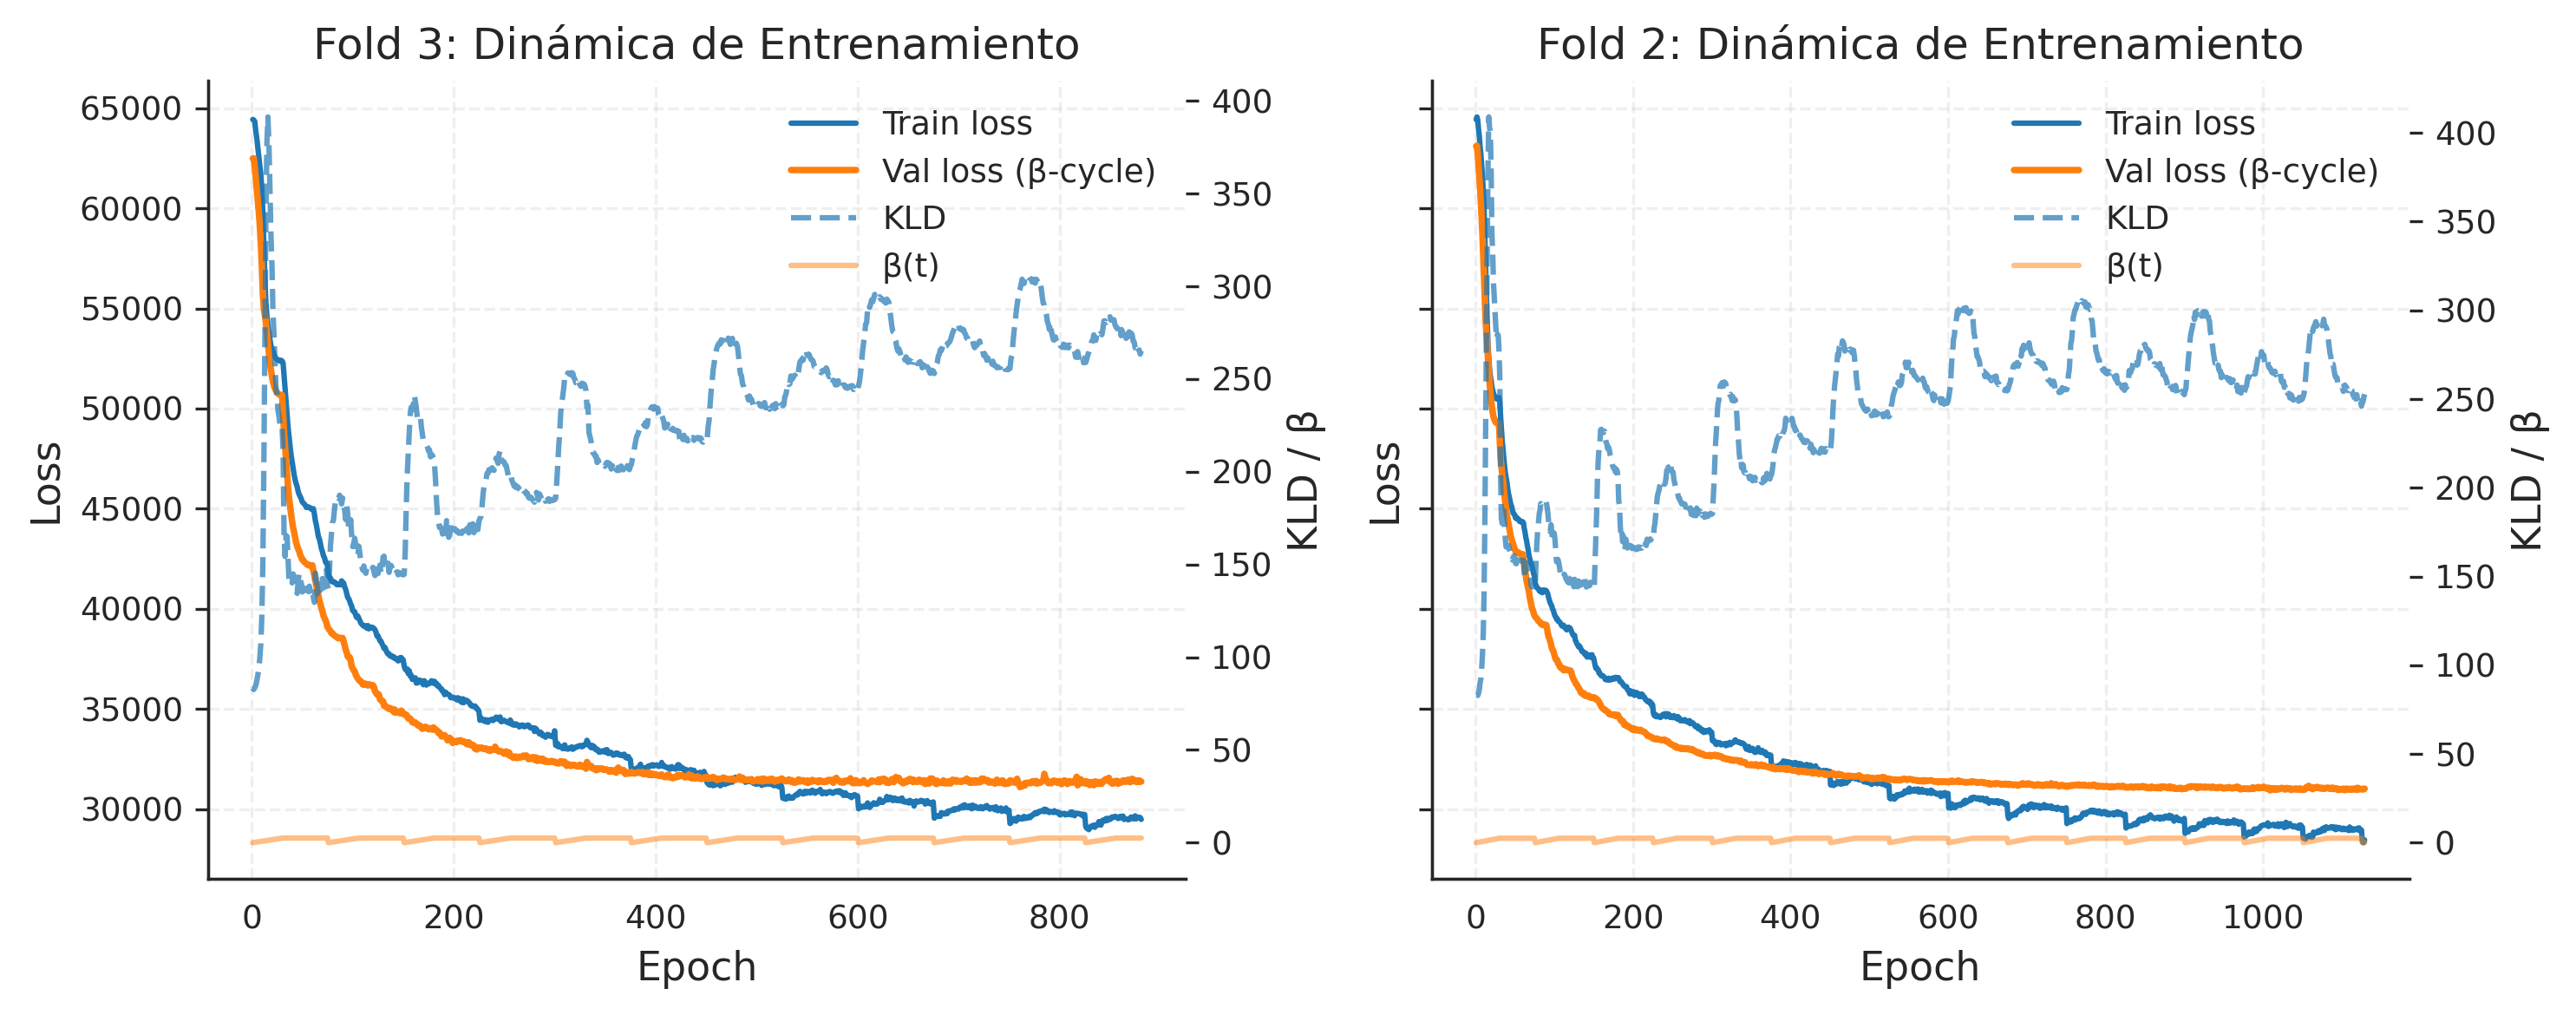

[OK] Dinámica VAE guardada.


In [6]:
# ===================== CELDA 4: DINÁMICA DE ENTRENAMIENTO VAE =====================
if vae_histories is None:
    print("[WARN] No se cargaron historias de entrenamiento del VAE.")
else:
    # identificamos fold con mejor y peor AUC
    best_fold = int(df_summary.loc[df_summary["auc"].idxmax(), "fold"])
    worst_fold = int(df_summary.loc[df_summary["auc"].idxmin(), "fold"])
    folds_to_plot = [best_fold, worst_fold]

    print(f"Ploteando dinámica VAE para folds: best={best_fold}, worst={worst_fold}")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for ax, fold_k in zip(axes, folds_to_plot):
        history = vae_histories[fold_k - 1]  # lista, índice 0 → Fold 1

        epochs = np.arange(1, len(history["train_loss"]) + 1)
        ax.plot(epochs, history["train_loss"], label="Train loss", lw=1.5)
        ax.plot(epochs, history["val_loss_modelsel"], label="Val loss (β-cycle)", lw=1.8)

        ax2 = ax.twinx()
        ax2.plot(epochs, history["train_kld"], linestyle="--", alpha=0.7, label="KLD")
        ax2.plot(epochs, history["beta"], alpha=0.5, label="β(t)")

        ax.set_title(f"Fold {fold_k}: Dinámica de Entrenamiento")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True, linestyle="--", alpha=0.3)
        ax2.set_ylabel("KLD / β")

        # leyenda combinada
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc="upper right", frameon=False)

    fig.tight_layout()
    fig.savefig(OUTPUT_FIG_DIR / "figure_vae_training_dynamics_best_vs_worst.pdf", bbox_inches="tight")
    fig.savefig(OUTPUT_FIG_DIR / "figure_vae_training_dynamics_best_vs_worst.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("[OK] Dinámica VAE guardada.")



--- Fuga de Manufacturer por fold (Balanced Accuracy) ---


representation,connectome_norm,latent_mu
fold_tag,,
fold_1,0.704,0.685
fold_2,0.692,0.805
fold_3,0.736,0.756
fold_4,0.675,0.752
fold_5,0.581,0.677



--- Resumen por representación (mean±sd, median) ---


balanced_accuracy_mean               chance              \
                                  mean    std median   mean  std median   
representation                                                            
connectome_norm                  0.678  0.058  0.692  0.333  0.0  0.333   
latent_mu                        0.735  0.054  0.752  0.333  0.0  0.333   

                DeltaBA                
                   mean    std median  
representation                         
connectome_norm   0.344  0.058  0.358  
latent_mu         0.402  0.054  0.419

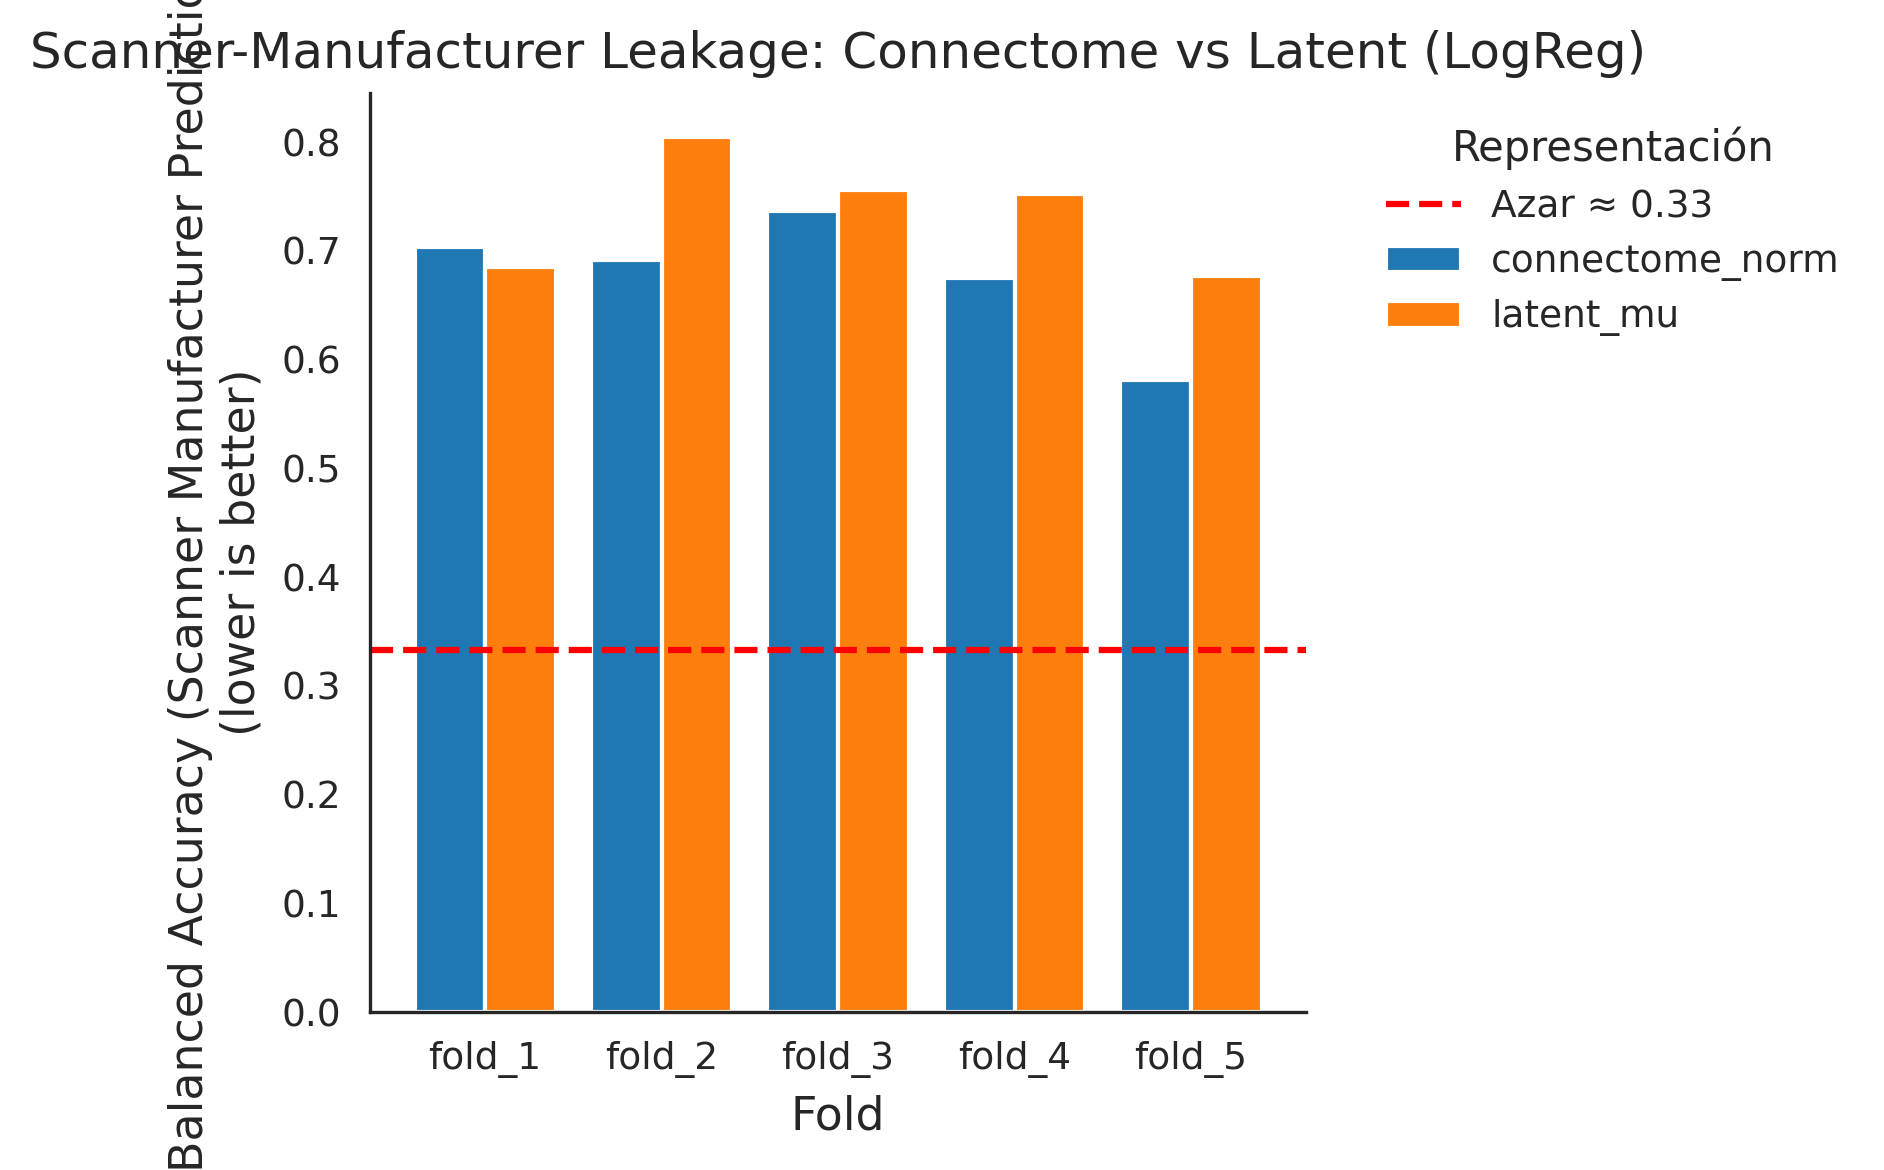

[OK] Tablas de Fuga de Manufacturer guardadas.


In [7]:
# ===================== CELDA 5: RESUMEN Fuga de Manufacturer (LOGREG) =====================
if leak_train is None:
    print("[WARN] No hay datos de leakage.")
else:
    df_leak_all = leak_train.copy()
    # por si no existe fold_tag
    if "fold_tag" not in df_leak_all.columns:
        df_leak_all["fold_tag"] = df_leak_all["fold"].map(lambda k: f"fold_{k}")

    pivot_leak = df_leak_all.pivot_table(
        index="fold_tag",
        columns="representation",
        values="balanced_accuracy_mean"
    )

    print("\n--- Fuga de Manufacturer por fold (Balanced Accuracy) ---")
    display(pivot_leak.round(3))

    # resumen global (media, std, Delta sobre azar)
    df = df_leak_all.copy()
    df["chance"] = 1.0 / df["n_classes"]
    df["DeltaBA"] = df["balanced_accuracy_mean"] - df["chance"]
    leak_summary_repr = (
        df.groupby("representation")[["balanced_accuracy_mean", "chance", "DeltaBA"]]
        .agg(["mean", "std", "median"])
        .round(3)
    )
    print("\n--- Resumen por representación (mean±sd, median) ---")
    display(leak_summary_repr)

    # gráfica
    fig, ax = plt.subplots(figsize=(6, 4))
    pivot_leak.plot(kind="bar", ax=ax, width=0.8, rot=0)
    ax.set_ylabel("Balanced Accuracy (Scanner Manufacturer Prediction)\n(lower is better)")


    ax.set_xlabel("Fold")
    ax.axhline(df["chance"].mean(), color="red", ls="--",
               label=f"Azar ≈ {df['chance'].mean():.2f}")
    ax.set_title("Scanner-Manufacturer Leakage: Connectome vs Latent (LogReg)")
    ax.legend(title="Representación", frameon=False, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    fig.savefig(OUTPUT_FIG_DIR / "figure_scanner_leakage_summary.pdf", bbox_inches="tight")
    fig.savefig(OUTPUT_FIG_DIR / "figure_scanner_leakage_summary.png", dpi=300, bbox_inches="tight")
    plt.show()

    # guardamos tablas
    pivot_leak.to_csv(OUTPUT_FIG_DIR / "table_scanner_leakage_by_fold.csv")
    leak_summary_repr.to_csv(OUTPUT_FIG_DIR / "table_scanner_leakage_summary.csv")
    print("[OK] Tablas de Fuga de Manufacturer guardadas.")


[INFO] Visualizando fold 1 en /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/fold_1
[OK] Tensor global cargado. Shape: (431, 3, 131, 131)
[OK] Cargando checkpoint: vae_model_fold_1.pt


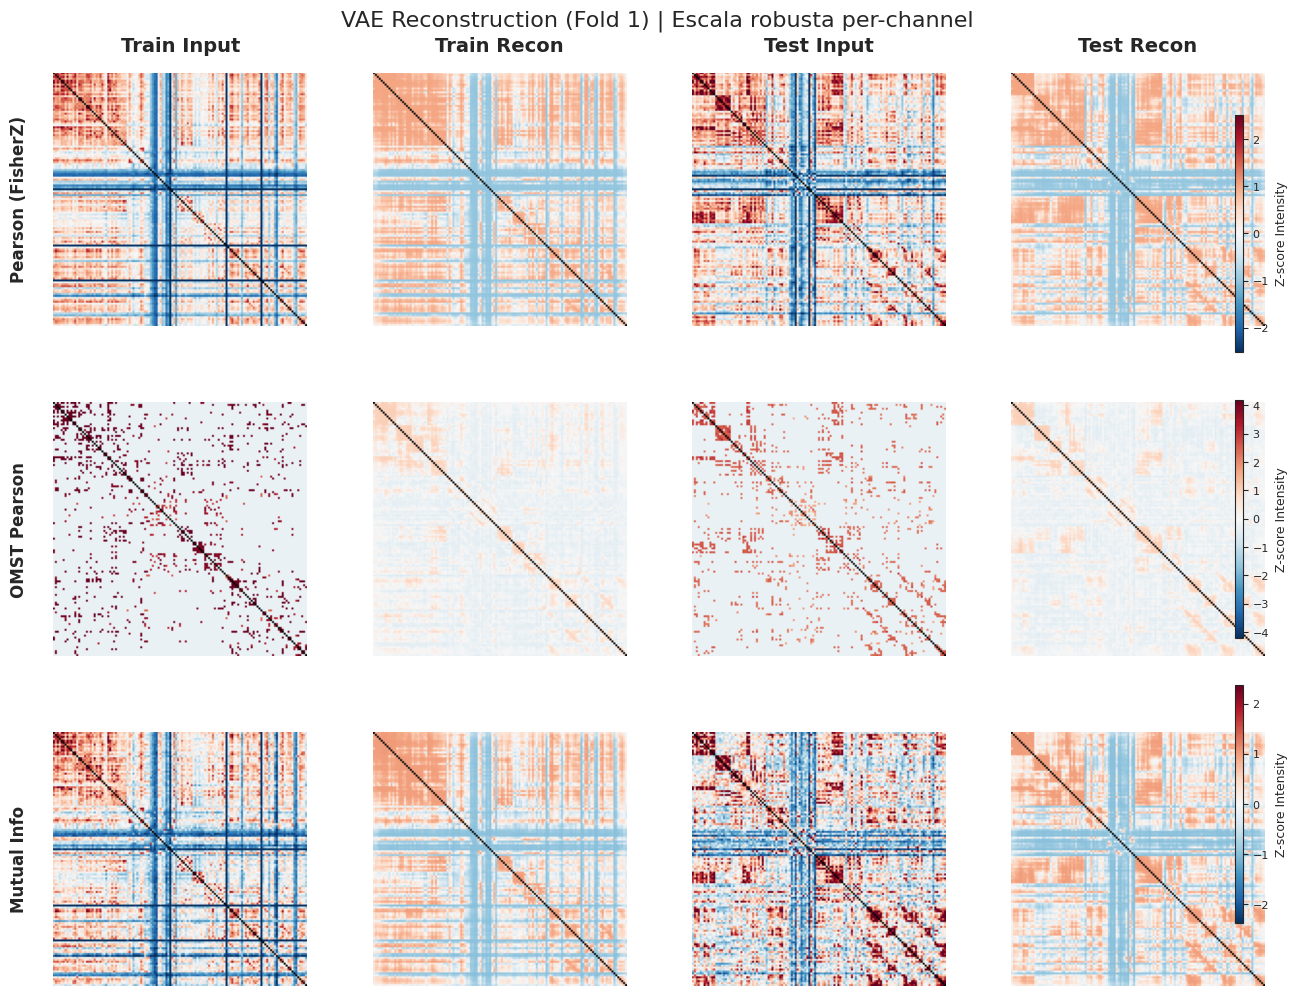

In [22]:
# ===================== CELDA 6 (FINAL): INPUT vs RECONSTRUCCIÓN (ROBUSTA) =====================
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import copy

# --- 1. CONFIGURACIÓN ---
project_root = Path.cwd().resolve().parent
src_dir = project_root / "src"
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

try:
    from betavae_xai.models.convolutional_vae import ConvolutionalVAE
except ImportError:
    from src.betavae_xai.models.convolutional_vae import ConvolutionalVAE

# PARÁMETROS (Deben coincidir con tu run_vae_clf_ad.py)
FOLD_TO_VIS = 1
LATENT_DIM = 256
NUM_CONV_LAYERS = 4  
INTERMEDIATE_FC = "quarter" 
DROPOUT = 0.2
LAYERNORM_FC = False 

fold_dir = RESULTS_DIR / f"fold_{FOLD_TO_VIS}"
print(f"[INFO] Visualizando fold {FOLD_TO_VIS} en {fold_dir}")

# --- 2. CARGAR DATOS Y PARÁMETROS ---
norm_params_path = fold_dir / "vae_norm_params.joblib"
if not norm_params_path.exists():
    raise FileNotFoundError(f"Faltan params normalización: {norm_params_path}")
norm_params_list = joblib.load(norm_params_path)

# Cargar Tensor Global
GLOBAL_TENSOR_PATH = project_root / "data/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz"
try:
    data_npz = np.load(GLOBAL_TENSOR_PATH, allow_pickle=True)
    CH_IDXS = [1, 0, 2] # Pearson, OMST Pearson, Mutual Info
    CH_NAMES = ['Pearson (FisherZ)', 'OMST Pearson', 'Mutual Info']
    global_t = data_npz['global_tensor_data'][:, CH_IDXS, :, :]
    print(f"[OK] Tensor global cargado. Shape: {global_t.shape}")
except FileNotFoundError:
    raise FileNotFoundError("No se encuentra el .npz global.")

# Selección de sujetos (Arbitrarios del tensor global para Demo)
subj_train_raw = global_t[10]   
subj_test_raw  = global_t[100]  

# --- 3. NORMALIZACIÓN BLINDADA (TU MEJORA) ---
def apply_norm_inference(tensor_mv, params_list):
    C, H, W = tensor_mv.shape
    normed = tensor_mv.copy()
    mask = ~np.eye(H, dtype=bool)
    
    for c in range(C):
        p = params_list[c]
        if not p.get('no_scale', False):
            vals = tensor_mv[c]
            
            if p.get('mode') == 'zscore_offdiag':
                # GUARD: Evitar división por cero
                if p['std'] > 1e-9:
                    normed[c, mask] = (vals[mask] - p['mean']) / p['std']
                else:
                    normed[c, mask] = 0.0
                    
            elif p.get('mode') == 'minmax_offdiag':
                rng = p['max'] - p['min']
                # GUARD: Evitar división por cero
                if rng > 1e-9:
                    normed[c, mask] = (vals[mask] - p['min']) / rng
                else:
                    normed[c, mask] = 0.0
    return normed

subj_train_norm = apply_norm_inference(subj_train_raw, norm_params_list)
subj_test_norm  = apply_norm_inference(subj_test_raw, norm_params_list)

# --- 4. INFERENCIA VAE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_channels = subj_train_norm.shape[0]
img_size = subj_train_norm.shape[1]

# Instanciación Robusta (con Fallback)
try:
    vae = ConvolutionalVAE(
        input_channels=n_channels,
        latent_dim=LATENT_DIM,
        image_size=img_size,
        num_conv_layers_encoder=NUM_CONV_LAYERS, 
        intermediate_fc_dim_config=INTERMEDIATE_FC, 
        dropout_rate=DROPOUT,
        use_layernorm_fc=LAYERNORM_FC,
        decoder_type="convtranspose",
        final_activation="tanh"
    ).to(device)
    
    ckpt_path = list(fold_dir.glob("vae_model_fold_*.pt"))[0]
    print(f"[OK] Cargando checkpoint: {ckpt_path.name}")
    vae.load_state_dict(torch.load(ckpt_path, map_location=device))
    
except RuntimeError:
    print("\n[WARN] Mismatch de arquitectura detectado. Intentando fallback (FC=0)...")
    vae = ConvolutionalVAE(
        input_channels=n_channels,
        latent_dim=LATENT_DIM,
        image_size=img_size,
        num_conv_layers_encoder=NUM_CONV_LAYERS, 
        intermediate_fc_dim_config=0, 
        dropout_rate=DROPOUT,
        use_layernorm_fc=LAYERNORM_FC,
        decoder_type="convtranspose",
        final_activation="tanh"
    ).to(device)
    vae.load_state_dict(torch.load(ckpt_path, map_location=device))
    print("[OK] Carga exitosa con fallback.")

vae.eval()

# Forward pass
x_tr = torch.from_numpy(subj_train_norm).float().unsqueeze(0).to(device)
x_te = torch.from_numpy(subj_test_norm).float().unsqueeze(0).to(device)

with torch.no_grad():
    recon_tr, _, _, _ = vae(x_tr)
    recon_te, _, _, _ = vae(x_te)

x_tr_np = x_tr.cpu().numpy()[0]
x_te_np = x_te.cpu().numpy()[0]
recon_tr_np = recon_tr.cpu().numpy()[0]
recon_te_np = recon_te.cpu().numpy()[0]

# --- 5. VISUALIZACIÓN ROBUSTA Y ESTÉTICA ---
def plot_matrix(ax, mat, vmin, vmax):
    """Helper simplificado: ya no pone título internamente para controlar mejor el layout"""
    mat_masked = mat.copy()
    np.fill_diagonal(mat_masked, np.nan) # Diagonal negra
    cmap = copy.copy(plt.cm.RdBu_r)
    cmap.set_bad(color='black')
    im = ax.imshow(mat_masked, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.axis('off')
    return im

# Aumentamos la altura de la figura y el ancho para dar aire
fig, axes = plt.subplots(n_channels, 4, figsize=(16, 3.5 * n_channels))

cols = ["Train Input", "Train Recon", "Test Input", "Test Recon"]

# 1. Poner títulos de columnas SOLO en la primera fila (más limpio)
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=14, fontweight='bold', pad=15)

for i in range(n_channels):
    # Escala robusta (percentiles 2-98%)
    flat_vals = np.concatenate([x_tr_np[i].flatten(), recon_tr_np[i].flatten()])
    flat_vals = flat_vals[np.isfinite(flat_vals)]
    vmax = np.percentile(np.abs(flat_vals), 98) 
    vmin = -vmax
    
    # 2. Plotear sin títulos individuales
    plot_matrix(axes[i, 0], x_tr_np[i], vmin, vmax)
    plot_matrix(axes[i, 1], recon_tr_np[i], vmin, vmax)
    plot_matrix(axes[i, 2], x_te_np[i], vmin, vmax)
    im = plot_matrix(axes[i, 3], recon_te_np[i], vmin, vmax)
    
    # 3. Poner el nombre del canal a la IZQUIERDA (Eje Y)
    # Usamos text o set_ylabel en un eje invisible o activando el eje brevemente
    # La forma más limpia en matrices sin ejes es usar annotation o text:
    axes[i, 0].text(-0.1, 0.5, CH_NAMES[i], transform=axes[i, 0].transAxes, 
                    fontsize=12, fontweight='bold', rotation=90, 
                    va='center', ha='right')

    # 4. Colorbar dedicada a la derecha de la fila
    # fraction: tamaño de la barra respecto al plot
    # pad: separación respecto al plot derecho
    cbar = fig.colorbar(im, ax=axes[i, :], location='right', fraction=0.05, pad=0.03, aspect=30)
    cbar.set_label("Z-score Intensity", fontsize=9)
    cbar.ax.tick_params(labelsize=8)

# Ajuste global de espacios
plt.suptitle(f"VAE Reconstruction (Fold {FOLD_TO_VIS}) | Escala robusta per-channel", fontsize=16, y=0.98)

# Ajustamos márgenes manualmente para evitar que se pisen
plt.subplots_adjust(wspace=0.1, hspace=0.3, top=0.92, bottom=0.05, left=0.1, right=0.88)

plt.show()

[OK] Archivo de predicciones encontrado:
all_folds_clf_predictions_MULTI_xgb_vaeconvtranspose4l_ld256_beta2.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.2_ln0_outer5x1_scoreroc_auc.joblib
[OK] Predicciones concatenadas para 'logreg': N=184
[INFO] Prevalencia global AD: 51.6%
Realizando análisis de bootstrap (puede tardar un momento)...
✅ Análisis de bootstrap completado.
[INFO] ROC-AUC Pooled Test: 0.829


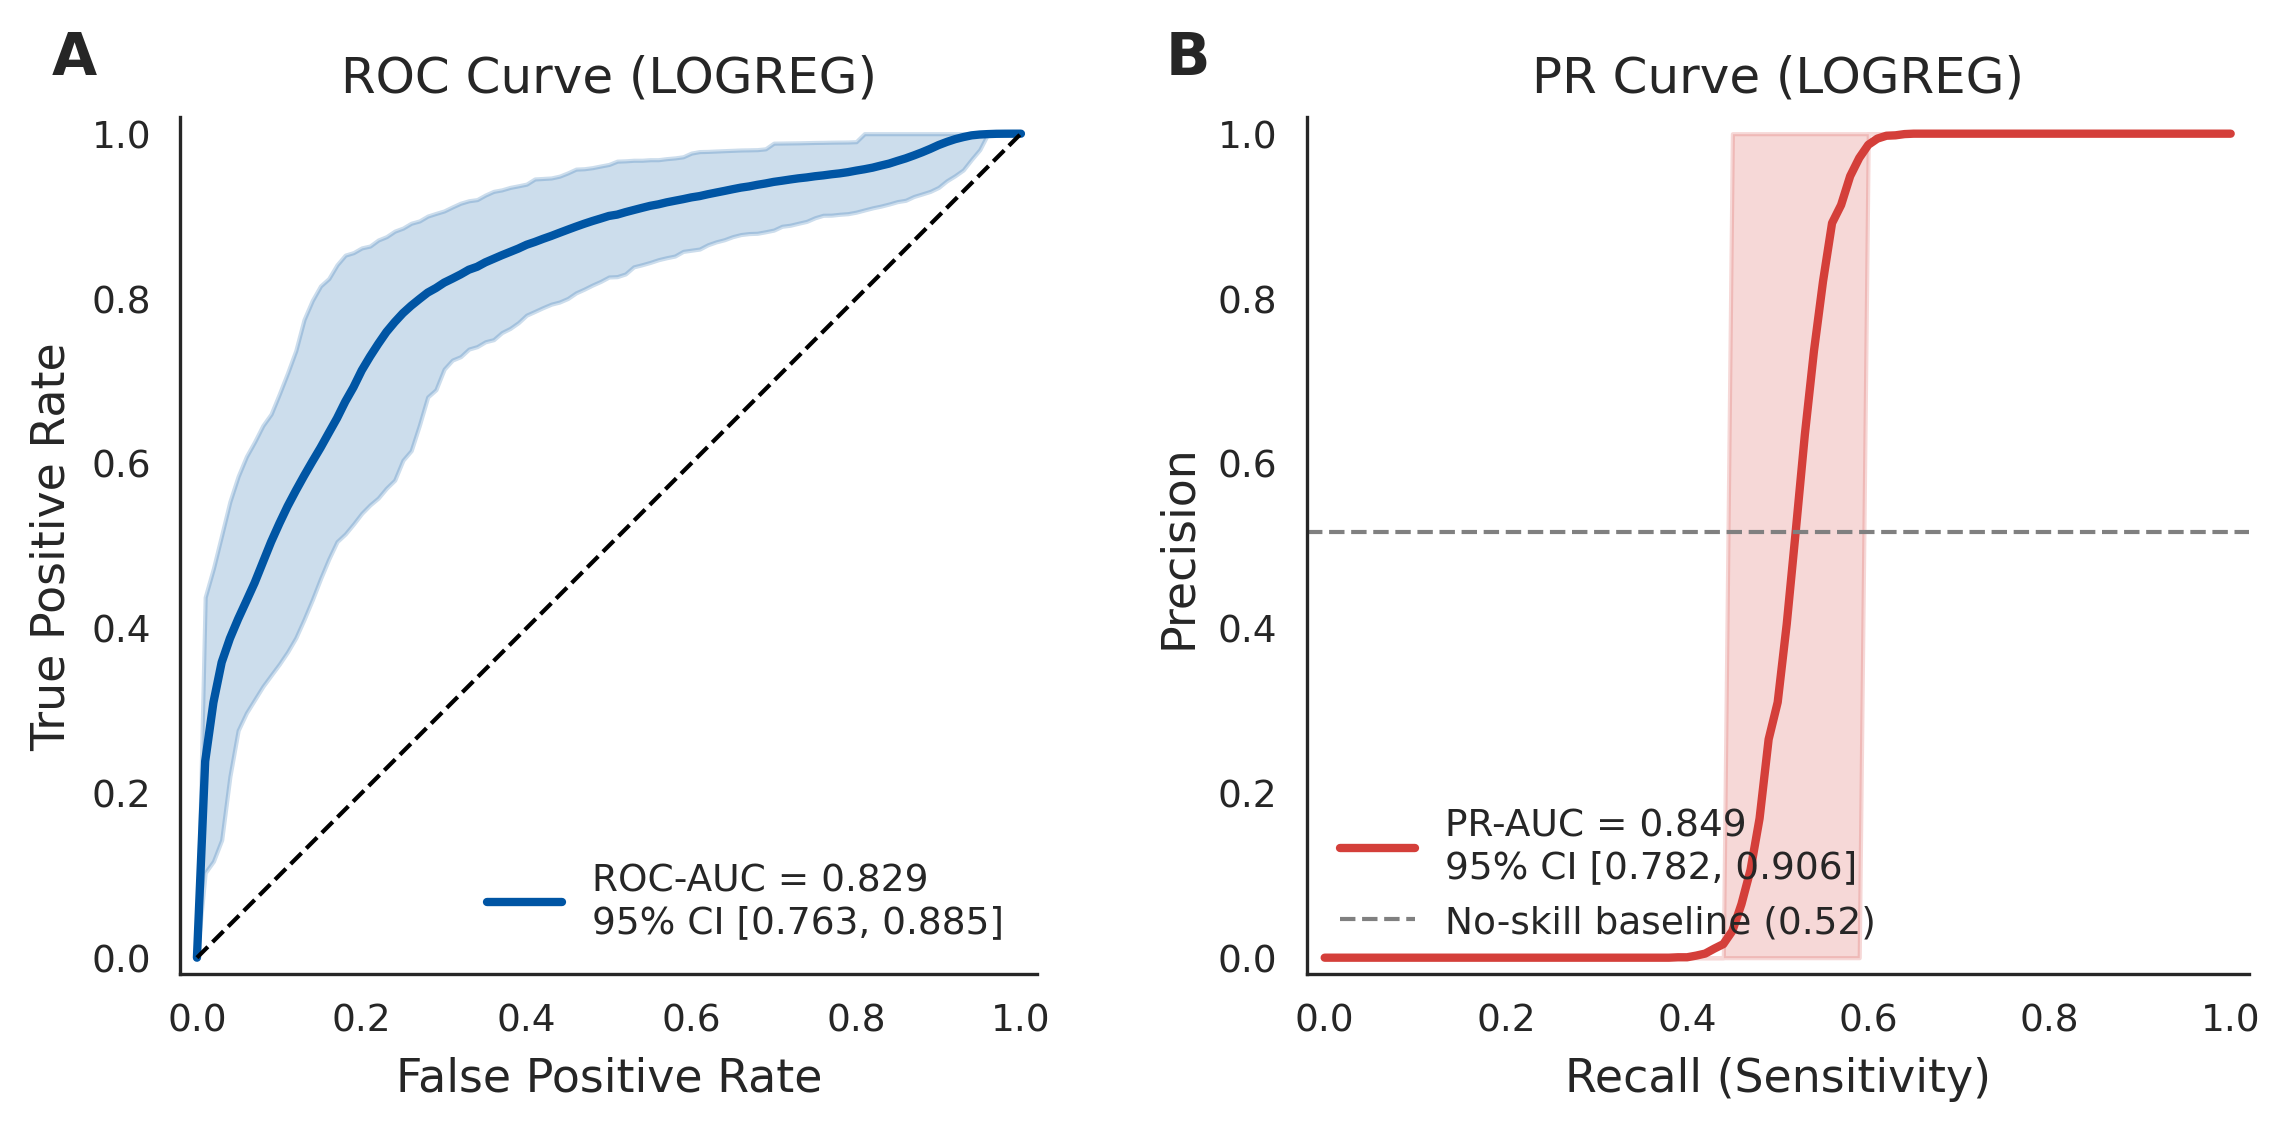


🎉 ¡Figura mejorada guardada en formatos PDF, PNG y SVG en: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/training_qc/figure_performance_curves_publication_logreg!


In [9]:
# ===================== CELDA 7: CURVAS ROC / PR (POOLED TEST) - ESTILO Q1 =====================
from sklearn.metrics import (
    roc_curve, precision_recall_curve,
    roc_auc_score, average_precision_score
)

# --- 1. CARGA DE DATOS ROBUSTA (Desde .joblib) ---
try:
    # Buscamos el archivo joblib que contiene las predicciones de TODOS los folds
    pred_joblib_path = next(RESULTS_DIR.glob("all_folds_clf_predictions_MULTI_*.joblib"))
    print(f"[OK] Archivo de predicciones encontrado:\n{pred_joblib_path.name}")
    
    # Cargamos la lista de diccionarios
    all_preds_data = joblib.load(pred_joblib_path)
    
    # Filtramos solo las tablas del clasificador que nos interesa (TARGET_CLF)
    relevant_dfs = []
    for item in all_preds_data:
        if item['classifier'] == TARGET_CLF:
            relevant_dfs.append(item['predictions_df'])
            
    if not relevant_dfs:
        raise ValueError(f"No se encontraron predicciones para '{TARGET_CLF}' en el archivo joblib.")
        
    # Concatenamos todos los folds en un solo DataFrame (Pooled Test Set)
    preds_df = pd.concat(relevant_dfs, ignore_index=True)
    print(f"[OK] Predicciones concatenadas para '{TARGET_CLF}': N={len(preds_df)}")

except StopIteration:
    raise FileNotFoundError(
        f"No se encontró el archivo 'all_folds_clf_predictions_MULTI_*.joblib' en {RESULTS_DIR}. "
        "Verifica que el pipeline terminó correctamente."
    )

# Definimos vectores finales
y_true = preds_df["y_true"].values
y_prob = preds_df["y_prob"].values
print(f"[INFO] Prevalencia global AD: {y_true.mean():.1%}")

# ==============================================================================
# --- 2. ANÁLISIS DE BOOTSTRAP Y VISUALIZACIÓN (VERSIÓN MEJORADA) ---
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

print("Realizando análisis de bootstrap (puede tardar un momento)...")
rng = np.random.default_rng(42)
B = 2000  # Número de remuestreos

# --- Bootstrap para la curva ROC ---
fpr_grid = np.linspace(0, 1, 101)
tprs, aucs_roc = [], []
for _ in range(B):
    # Muestreo con reemplazo
    idx = rng.integers(0, len(y_true), len(y_true))
    if len(np.unique(y_true[idx])) < 2: continue
    
    fpr_i, tpr_i, _ = roc_curve(y_true[idx], y_prob[idx])
    tpr_interp = np.interp(fpr_grid, fpr_i, tpr_i)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    aucs_roc.append(roc_auc_score(y_true[idx], y_prob[idx]))

tprs = np.array(tprs)
tpr_mean = tprs.mean(0)
tpr_low = np.percentile(tprs, 2.5, 0)
tpr_high = np.percentile(tprs, 97.5, 0)
auc_roc_low, auc_roc_high = np.percentile(aucs_roc, [2.5, 97.5])

# --- Bootstrap para la curva PR ---
recall_grid = np.linspace(0, 1, 101)
precs, aucs_pr = [], []
for _ in range(B):
    idx = rng.integers(0, len(y_true), len(y_true))
    if len(np.unique(y_true[idx])) < 2: continue
    
    r, p, _ = precision_recall_curve(y_true[idx], y_prob[idx])
    # Invertimos para interpolar (recall decreciente -> creciente)
    p_interp = np.interp(recall_grid, r[::-1], p[::-1])
    precs.append(p_interp)
    aucs_pr.append(average_precision_score(y_true[idx], y_prob[idx]))

precs = np.array(precs)
prec_mean = precs.mean(0)
prec_low = np.percentile(precs, 2.5, 0)
prec_high = np.percentile(precs, 97.5, 0)
auc_pr_low, auc_pr_high = np.percentile(aucs_pr, [2.5, 97.5])

print("✅ Análisis de bootstrap completado.")

# ==============================================================================
# --- Creación de la figura final con estilo de publicación ---
# ==============================================================================
# 1. Definir estilo y colores
plt.style.use('default') # Reset a un estilo base
sns.set_style("white") # Fondo blanco sin grilla por defecto

# Parámetros para un look profesional (calidad de revista)
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"], # Fuentes limpias
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.dpi": 300,
    "axes.spines.top": False, # Eliminar bordes superior y derecho
    "axes.spines.right": False,
    "pdf.fonttype": 42, # Embeber fuentes en PDF como TrueType
    "ps.fonttype": 42
})

# Paleta de colores profesional
COLOR_ROC = '#0055A4' # Azul Francia
COLOR_PR  = '#D43F3A' # Rojo Ladrillo

# 2. Creación de la figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4)) # Un poco más compacto

# --- Panel A y Panel B: preparar labels de las leyendas ---
auc_pooled_roc = roc_auc_score(y_true, y_prob)
print(f"[INFO] ROC-AUC Pooled Test: {auc_pooled_roc:.3f}")
roc_label = (f'ROC-AUC = {auc_pooled_roc:.3f}\n'
             f'95% CI [{auc_roc_low:.3f}, {auc_roc_high:.3f}]')

auc_pooled_pr = average_precision_score(y_true, y_prob)
pr_label = (
    f'PR-AUC = {auc_pooled_pr:.3f}\n'
    f'95% CI [{auc_pr_low:.3f}, {auc_pr_high:.3f}]'
)

# --- Panel A: Curva ROC ---
ax1.plot(fpr_grid, tpr_mean, color=COLOR_ROC, lw=2, label=roc_label)
ax1.fill_between(fpr_grid, tpr_low, tpr_high, color=COLOR_ROC, alpha=0.2)
ax1.set_aspect('equal', 'box')
ax1.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
ax1.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02],
        xlabel='False Positive Rate', ylabel='True Positive Rate',
        title=f'ROC Curve ({TARGET_CLF.upper()})')
ax1.legend(loc="lower right", frameon=False)
ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold')

# --- Panel B: Curva PR ---
baseline = np.sum(y_true) / len(y_true)
ax2.plot(recall_grid, prec_mean, color=COLOR_PR, lw=2, label=pr_label)
ax2.fill_between(recall_grid, prec_low, prec_high, color=COLOR_PR, alpha=0.2)
ax2.axhline(baseline, color='grey', linestyle='--', lw=1, label=f'No-skill baseline ({baseline:.2f})')
ax2.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02],
        xlabel='Recall (Sensitivity)', ylabel='Precision',
        title=f'PR Curve ({TARGET_CLF.upper()})')
ax2.legend(loc="lower left", frameon=False)
ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold')

# 3. Guardar en múltiples formatos (vectorial y raster) y mostrar
fig.tight_layout(pad=1.5)
fig_path_base = OUTPUT_FIG_DIR / f"figure_performance_curves_publication_{TARGET_CLF}"

# Guardar en los formatos
plt.savefig(f"{fig_path_base}.pdf", bbox_inches='tight')
plt.savefig(f"{fig_path_base}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"{fig_path_base}.svg", bbox_inches='tight')

plt.show()
print(f"\n🎉 ¡Figura mejorada guardada en formatos PDF, PNG y SVG en: {fig_path_base}!")

[OK] Se encontraron datos para 5 folds del clasificador 'logreg'.
Mean ROC-AUC: 0.843 ± 0.062
Mean PR-AUC:  0.864 ± 0.051


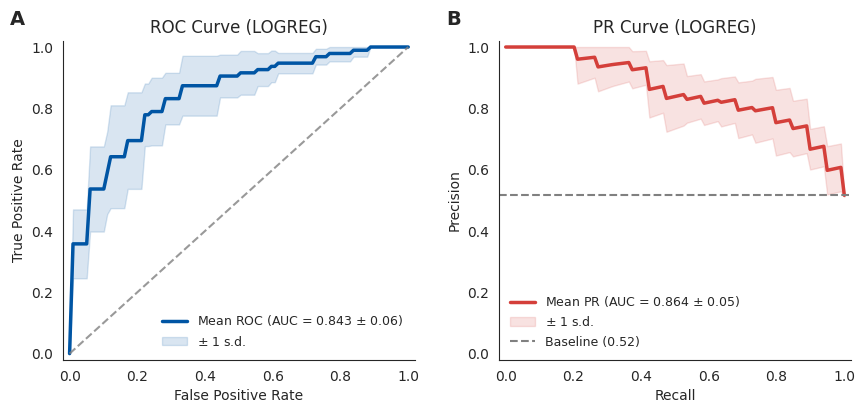

Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/training_qc/figure_performance_curves_MEAN_logreg.png


In [10]:
# ===================== CELDA 7 (CORREGIDA): MEAN ROC & PR CURVES (Coincide con Tabla) =====================
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, auc

# --- 1. CARGA DE DATOS ---
try:
    pred_joblib_path = next(RESULTS_DIR.glob("all_folds_clf_predictions_MULTI_*.joblib"))
    all_preds_data = joblib.load(pred_joblib_path)
    
    # Separamos las predicciones POR FOLD
    fold_predictions = {} 
    for item in all_preds_data:
        if item['classifier'] == TARGET_CLF:
            # Intentamos obtener el ID del fold
            f_id = item.get('fold', None)
            if f_id is None and 'fold' in item['predictions_df'].columns:
                f_id = item['predictions_df']['fold'].iloc[0]
            
            if f_id is not None:
                fold_predictions[f_id] = item['predictions_df']

    print(f"[OK] Se encontraron datos para {len(fold_predictions)} folds del clasificador '{TARGET_CLF}'.")

except StopIteration:
    raise FileNotFoundError("No se encontró el joblib de predicciones.")

# ==============================================================================
# --- 2. CÁLCULO DE CURVAS PROMEDIO (Mean ROC) ---
# ==============================================================================
# Grilla común para interpolar
mean_fpr = np.linspace(0, 1, 100)
mean_recall = np.linspace(0, 1, 100)

tprs = []
precs = []
aucs_roc_folds = []
aucs_pr_folds = []
baseline_global = np.mean([df["y_true"].mean() for df in fold_predictions.values()])

# Iteramos sobre cada fold
for f_id, df_fold in fold_predictions.items():
    y_true_f = df_fold["y_true"].values
    y_prob_f = df_fold["y_prob"].values
    
    # --- ROC ---
    fpr_f, tpr_f, _ = roc_curve(y_true_f, y_prob_f)
    tpr_interp = np.interp(mean_fpr, fpr_f, tpr_f)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    aucs_roc_folds.append(roc_auc_score(y_true_f, y_prob_f))
    
    # --- PR ---
    precision_f, recall_f, _ = precision_recall_curve(y_true_f, y_prob_f)
    # Invertimos recall para que sea creciente para la interpolación
    prec_interp = np.interp(mean_recall, recall_f[::-1], precision_f[::-1])
    precs.append(prec_interp)
    aucs_pr_folds.append(average_precision_score(y_true_f, y_prob_f))

# Promedios y Desvío Estándar (ROC)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
std_tpr = np.std(tprs, axis=0)
mean_auc_roc = np.mean(aucs_roc_folds) # Debe dar ~0.843
std_auc_roc = np.std(aucs_roc_folds)   # Debe dar ~0.069

# Promedios y Desvío Estándar (PR)
mean_precision = np.mean(precs, axis=0)
std_precision = np.std(precs, axis=0)
mean_auc_pr = np.mean(aucs_pr_folds)
std_auc_pr = np.std(aucs_pr_folds)

print(f"Mean ROC-AUC: {mean_auc_roc:.3f} ± {std_auc_roc:.3f}")
print(f"Mean PR-AUC:  {mean_auc_pr:.3f} ± {std_auc_pr:.3f}")

# ==============================================================================
# --- 3. PLOT DE PUBLICACIÓN (Mean Curve ± SD) ---
# ==============================================================================
plt.style.use('default')
sns.set_style("white")
mpl.rcParams.update({
    "font.family": "sans-serif", "font.size": 10, 
    "axes.spines.top": False, "axes.spines.right": False
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5))

# Colores Profesionales
COLOR_ROC = '#0055A4'
COLOR_PR  = '#D43F3A'

# --- PANEL A: ROC ---
ax1.plot(mean_fpr, mean_tpr, color=COLOR_ROC, lw=2.5,
         label=r'Mean ROC (AUC = %0.3f $\pm$ %0.2f)' % (mean_auc_roc, std_auc_roc))

# Banda de error (± 1 std dev)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color=COLOR_ROC, alpha=0.15, label=r'$\pm$ 1 s.d.')

ax1.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='gray', alpha=0.8)
ax1.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02],
        xlabel='False Positive Rate', ylabel='True Positive Rate',
        title=f'ROC Curve ({TARGET_CLF.upper()})')
ax1.legend(loc="lower right", frameon=False, fontsize=9)
ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold')

# --- PANEL B: PR ---
ax2.plot(mean_recall, mean_precision, color=COLOR_PR, lw=2.5,
         label=r'Mean PR (AUC = %0.3f $\pm$ %0.2f)' % (mean_auc_pr, std_auc_pr))

# Banda de error
precs_upper = np.minimum(mean_precision + std_precision, 1)
precs_lower = np.maximum(mean_precision - std_precision, 0)
ax2.fill_between(mean_recall, precs_lower, precs_upper, color=COLOR_PR, alpha=0.15, label=r'$\pm$ 1 s.d.')

ax2.axhline(baseline_global, color='gray', linestyle='--', lw=1.5, label=f'Baseline ({baseline_global:.2f})')
ax2.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02],
        xlabel='Recall', ylabel='Precision',
        title=f'PR Curve ({TARGET_CLF.upper()})')
ax2.legend(loc="lower left", frameon=False, fontsize=9)
ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold')

fig.tight_layout(pad=2.0)
fig_path_base = OUTPUT_FIG_DIR / f"figure_performance_curves_MEAN_{TARGET_CLF}"
plt.savefig(f"{fig_path_base}.pdf", bbox_inches='tight')
plt.savefig(f"{fig_path_base}.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"Guardado: {fig_path_base}.png")

In [11]:
# ===================== CELDA 7.5: OPERATING POINTS (Para Supplementary Table S3) =====================
# Calculamos los puntos de operación sobre las predicciones concatenadas (Pooled)
# Esto es estándar para reportar umbrales clínicos únicos.

from sklearn.metrics import confusion_matrix

# Usamos y_true, y_prob que ya cargaste en la Celda 7 (versión concatenada)
fpr_pool, tpr_pool, thresholds_pool = roc_curve(y_true, y_prob)

# 1. Youden Index (J = Sen + Esp - 1)
J = tpr_pool - fpr_pool
ix_youden = np.argmax(J)
thresh_youden = thresholds_pool[ix_youden]

# 2. Screening (Sensibilidad >= 0.85)
# Buscamos el umbral más alto que mantenga Sen >= 0.85
ix_screen = np.where(tpr_pool >= 0.85)[0]
# Como tpr es creciente, tomamos el primer índice que cumpla (el más cercano a 0.85 por arriba)
# Ojo: roc_curve devuelve thresholds decrecientes
if len(ix_screen) > 0:
    # El índice más bajo en tpr_pool corresponde al threshold más ALTO (más estricto)
    # Queremos el threshold más alto posible que aun de sen >= 0.85
    ix_screen_best = ix_screen[0] 
    thresh_screen = thresholds_pool[ix_screen_best]
else:
    thresh_screen = 0.5 # fallback

def print_metrics_at_threshold(y_t, y_p, thresh, name):
    y_pred = (y_p >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_t, y_pred).ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    ppv = tp / (tp + fp) if (tp+fp)>0 else 0
    npv = tn / (tn + fn) if (tn+fn)>0 else 0
    print(f"--- {name} (Thresh={thresh:.3f}) ---")
    print(f"  Sen (AD): {sens:.3f} | Spe (CN): {spec:.3f}")
    print(f"  PPV:      {ppv:.3f} | NPV:      {npv:.3f}")
    print(f"  Counts: TP={tp}, FN={fn}, TN={tn}, FP={fp}")

print("\n=== POST HOC OPERATING POINTS (Pooled N=184) ===")
print_metrics_at_threshold(y_true, y_prob, thresh_youden, "Youden Index")
print_metrics_at_threshold(y_true, y_prob, thresh_screen, "Screening Mode")


=== POST HOC OPERATING POINTS (Pooled N=184) ===
--- Youden Index (Thresh=0.500) ---
  Sen (AD): 0.800 | Spe (CN): 0.775
  PPV:      0.792 | NPV:      0.784
  Counts: TP=76, FN=19, TN=69, FP=20
--- Screening Mode (Thresh=0.472) ---
  Sen (AD): 0.853 | Spe (CN): 0.640
  PPV:      0.717 | NPV:      0.803
  Counts: TP=81, FN=14, TN=57, FP=32


In [12]:
# ===================== CELDA 7.5b: COST-BASED OPERATING POINT (C_fn = 3) =====================
from sklearn.metrics import confusion_matrix

def metrics_at_threshold(y_t, y_p, thresh):
    """Devuelve métricas + counts en un dict, dado un umbral."""
    y_pred = (y_p >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_t, y_pred).ravel()

    sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    ppv  = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    npv  = tn / (tn + fn) if (tn + fn) > 0 else np.nan

    return {
        "thresh": thresh,
        "sens": sens,
        "spec": spec,
        "ppv": ppv,
        "npv": npv,
        "tp": tp,
        "fn": fn,
        "tn": tn,
        "fp": fp,
    }

def cost_at_threshold(y_t, y_p, thresh, C_fn=3.0, C_fp=1.0):
    """Costo medio por sujeto dado un umbral y costos C_fn, C_fp."""
    y_pred = (y_p >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_t, y_pred).ravel()
    total_cost = C_fn * fn + C_fp * fp
    return total_cost / len(y_t)

# Usamos los mismos thresholds que vienen de roc_curve
costs = []
for thr in thresholds_pool:
    c = cost_at_threshold(y_true, y_prob, thr, C_fn=3.0, C_fp=1.0)
    costs.append(c)

ix_cost = int(np.argmin(costs))
thresh_cost = thresholds_pool[ix_cost]
metrics_cost = metrics_at_threshold(y_true, y_prob, thresh_cost)

print("\n--- Cost-based (C_fn = 3, C_fp = 1) ---")
print(f"  Threshold: {metrics_cost['thresh']:.3f}")
print(f"  Sen (AD):  {metrics_cost['sens']:.3f}")
print(f"  Spe (CN):  {metrics_cost['spec']:.3f}")
print(f"  PPV:       {metrics_cost['ppv']:.3f}")
print(f"  NPV:       {metrics_cost['npv']:.3f}")
print(f"  Counts: TP={metrics_cost['tp']}, FN={metrics_cost['fn']}, "
      f"TN={metrics_cost['tn']}, FP={metrics_cost['fp']}")



--- Cost-based (C_fn = 3, C_fp = 1) ---
  Threshold: 0.456
  Sen (AD):  0.874
  Spe (CN):  0.607
  PPV:       0.703
  NPV:       0.818
  Counts: TP=83, FN=12, TN=54, FP=35


Generando curva de calibración (Pooled Test)...


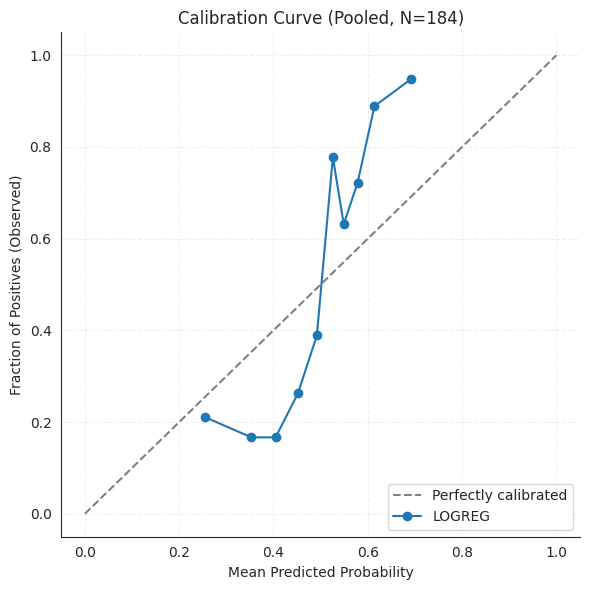

Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/training_qc/figure_calibration_pooled.pdf


In [13]:
# ===================== CELDA 7.6: CURVA DE CALIBRACIÓN (Para Fig S9) =====================
from sklearn.calibration import calibration_curve

print("Generando curva de calibración (Pooled Test)...")

# Calcular curva de calibración (10 bins es estándar)
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='quantile')

fig, ax = plt.subplots(figsize=(6, 6))

# Línea de referencia (Perfectamente calibrado)
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

# Curva del modelo
ax.plot(prob_pred, prob_true, marker='o', linewidth=1.5, color='C0', label=f'{TARGET_CLF.upper()}')

ax.set_xlabel("Mean Predicted Probability")
ax.set_ylabel("Fraction of Positives (Observed)")
ax.set_title(f"Calibration Curve (Pooled, N={len(y_true)})")
ax.legend(loc="lower right")
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
out_calib = OUTPUT_FIG_DIR / "figure_calibration_pooled.pdf"
plt.savefig(out_calib, bbox_inches='tight')
plt.show()
print(f"Guardado: {out_calib}")

In [14]:
from sklearn.metrics import brier_score_loss
brier = brier_score_loss(y_true, y_prob)
print(f"Pooled Brier Score: {brier:.3f}") 
# Si esto da 0.178, ¡estás blindado!

Pooled Brier Score: 0.197


In [15]:
# ===================== CELDA X: CARGA DE METADATOS COMPLETOS =====================
from pathlib import Path
import pandas as pd
import numpy as np

# Usamos el mismo project_root que en la celda 6
project_root = Path.cwd().resolve().parent

# Ruta del CSV original (la misma que usaste en run_vae_clf_ad.py)
metadata_path = project_root / "data/SubjectsData_AAL3_procesado2.csv"
metadata_df_full = pd.read_csv(metadata_path)

print("[OK] metadata_df_full cargado desde:", metadata_path)
print("Shape:", metadata_df_full.shape)
print("Columnas:", metadata_df_full.columns.tolist()[:10], "...")


[OK] metadata_df_full cargado desde: /home/diego/proyectos/betavae-xai-ad/data/SubjectsData_AAL3_procesado2.csv
Shape: (434, 33)
Columnas: ['SubjectID', 'Phase', 'Sex', 'ResearchGroup', 'Visit', 'ArchiveDate', 'StudyDate', 'Age', 'Modality', 'Description'] ...


In [16]:
# ¡Sólo si estás seguro de que el orden coincide!
# Por ejemplo, si ya filtraste metadata_df_full a los mismos 431 sujetos del tensor
metadata_df_full = metadata_df_full.reset_index(drop=True).copy()
metadata_df_full["tensor_idx"] = np.arange(len(metadata_df_full))
print("Metadata con índice de tensor añadido.")

Metadata con índice de tensor añadido.



--- Generando embeddings latentes de los datos de TEST de cada fold ---
✅ Argumentos cargados: Canales=[1, 0, 2], Dim Latente=256
✅ Embeddings de test generados para todos los folds.


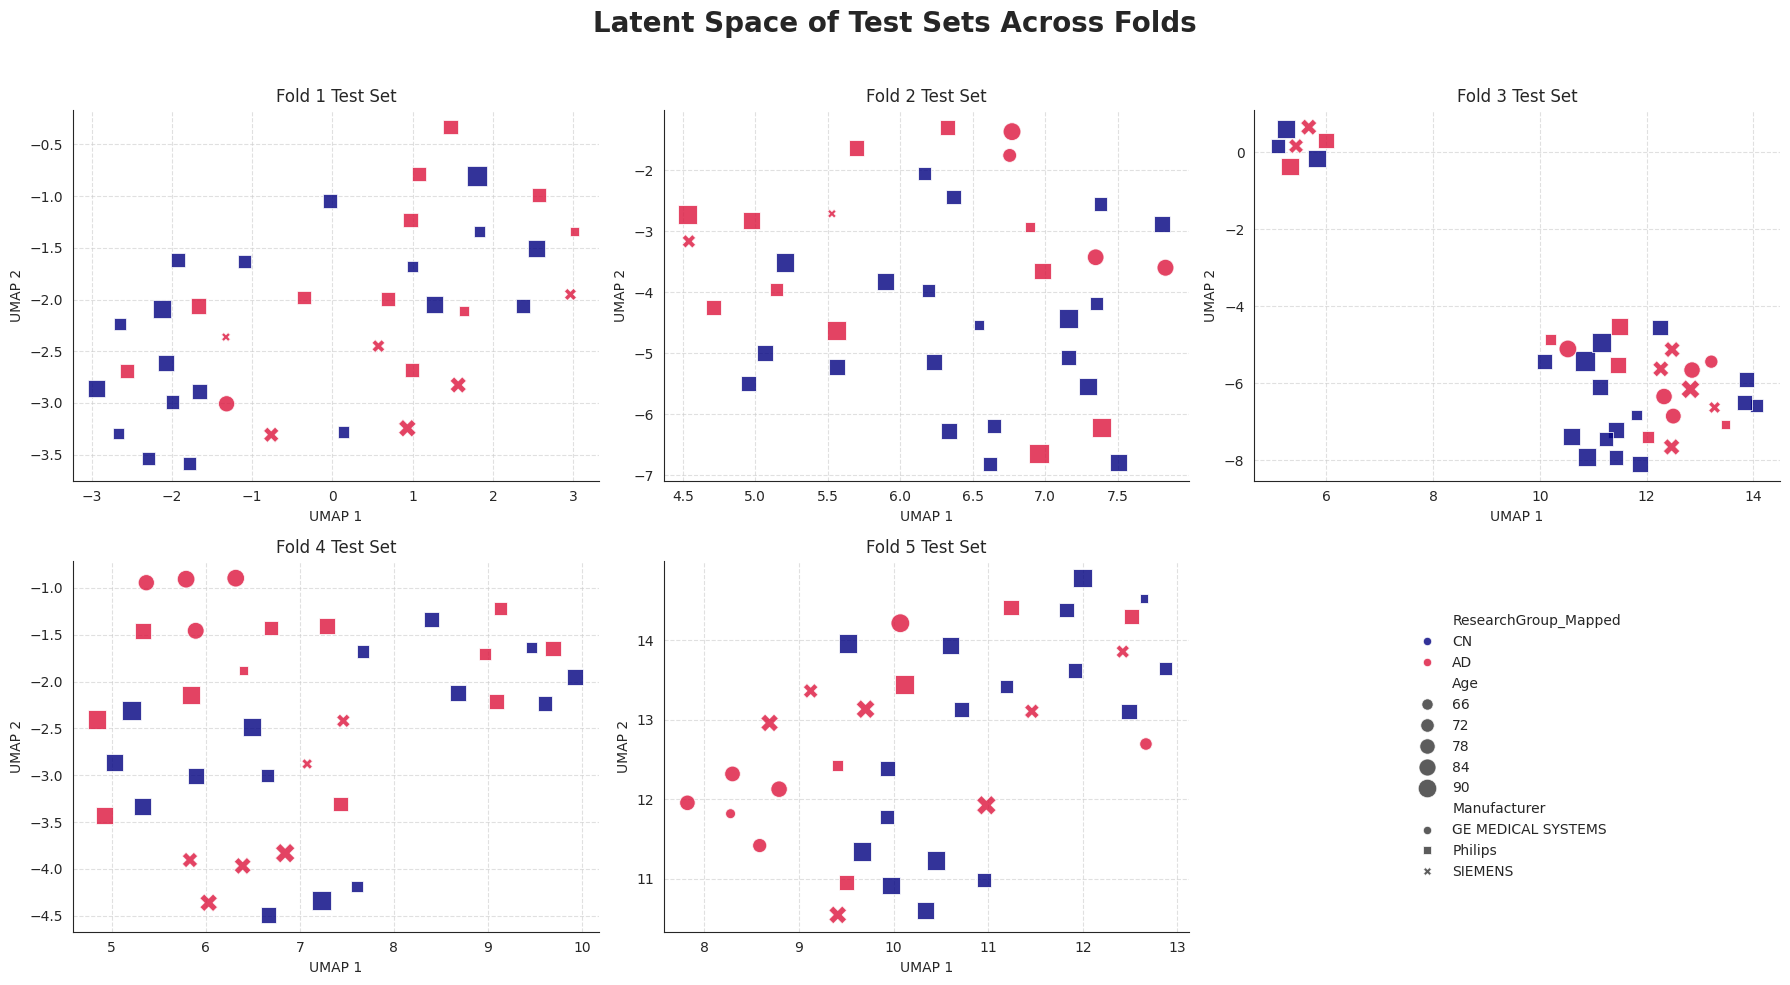

🎉 Figura UMAP por fold guardada en:
  /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/training_qc/figure2_umap_per_fold_detailed.png/.pdf/.svg


In [17]:
# ==============================================================================
# === CELDA 8: Figura 2 — Análisis del Espacio Latente por Fold (UMAP TEST) ===
# ==============================================================================

import logging
import re
import ast
import umap
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from pathlib import Path
import numpy as np
import pandas as pd
import joblib

# Silenciar logs molestos de fontTools al guardar SVG/PDF
logging.getLogger("fontTools.subset").setLevel(logging.ERROR)

# ------------------------------------------------------------------------------
# Pequeño wrapper: normalización por lotes usando tu función apply_norm_inference
# tensor_4d: (N, C, H, W)
# ------------------------------------------------------------------------------
def apply_norm_batch(tensor_4d: np.ndarray, params_list):
    """
    Aplica apply_norm_inference sujeto a sujeto.
    tensor_4d: (N, C, H, W)
    params_list: lista de diccionarios de normalización por canal.
    """
    N = tensor_4d.shape[0]
    normed = np.empty_like(tensor_4d)
    for i in range(N):
        normed[i] = apply_norm_inference(tensor_4d[i], params_list)
    return normed


# ------------------------------------------------------------------------------
# Comprobaciones mínimas: que existan las cosas que necesitamos
# - metrics_df: ya la tenés cargada arriba
# - data_npz / global_tensor_data: viene de la celda de reconstrucción VAE
# - metadata_df_full: debe existir en el entorno (mismo que usaste para entrenar)
# ------------------------------------------------------------------------------
if (
    "metrics_df" not in locals() or metrics_df is None
    or ("data_npz" not in locals() and "global_tensor_data" not in locals())
):
    print("⚠️ No se ejecuta el análisis UMAP porque faltan 'metrics_df' o el tensor global.")
else:
    # Aseguramos tener global_tensor_data desde el .npz
    if "global_tensor_data" not in locals():
        global_tensor_data = data_npz["global_tensor_data"]

    if "metadata_df_full" not in locals():
        print("⚠️ 'metadata_df_full' no está definido en este notebook.")
        print("   Cargá tu metadata (con columnas 'ResearchGroup_Mapped', 'Manufacturer', 'Age', 'tensor_idx').")
    else:
        print("\n--- Generando embeddings latentes de los datos de TEST de cada fold ---")

        # ----------------------------------------------------------------------
        # 1. Cargar argumentos del run desde summary_metrics*.txt (si existe)
        # ----------------------------------------------------------------------
        try:
            summary_files = list(RESULTS_DIR.glob("summary_metrics*.txt"))
            if not summary_files:
                raise FileNotFoundError("No se encontró summary_metrics*.txt en RESULTS_DIR.")

            with open(summary_files[0], "r") as f:
                txt = f.read()
            run_args = ast.literal_eval(re.search(r"\{.*\}", txt, re.DOTALL).group(0))

            print(
                f"✅ Argumentos cargados: Canales={run_args.get('channels_to_use')}, "
                f"Dim Latente={run_args.get('latent_dim')}"
            )
        except Exception as e:
            print(f"⚠️ No se pudo cargar 'run_args' desde summary_metrics*.txt ({e}). Usando fallback.")
            run_args = {
                "channels_to_use": [1, 2, 5],   # <-- ajusta si fuera necesario
                "latent_dim": 256,
                "num_conv_layers_encoder": 4,
                "decoder_type": "convtranspose",
                "vae_final_activation": "tanh",
                "intermediate_fc_dim_vae": "quarter",
                "dropout_rate_vae": 0.2,
                "use_layernorm_vae_fc": False,
            }

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Nos quedamos solo con CN/AD
        cn_ad_df = metadata_df_full[
            metadata_df_full["ResearchGroup_Mapped"].isin(["CN", "AD"])
        ].reset_index(drop=True)

        all_fold_data = []

        # ----------------------------------------------------------------------
        # 2. Para cada fold: cargar VAE, normalizar test set, obtener μ
        # ----------------------------------------------------------------------
        for i in range(1, N_FOLDS + 1):
            fold_dir = RESULTS_DIR / f"fold_{i}"

            # Instanciamos VAE con la misma configuración del run
            try:
                ConvolutionalVAE  # comprobamos si ya está importado
            except NameError:
                try:
                    from betavae_xai.models.convolutional_vae import ConvolutionalVAE
                except ImportError:
                    from src.betavae_xai.models.convolutional_vae import ConvolutionalVAE

            vae = ConvolutionalVAE(
                input_channels=len(run_args["channels_to_use"]),
                latent_dim=run_args["latent_dim"],
                image_size=global_tensor_data.shape[-1],
                num_conv_layers_encoder=run_args["num_conv_layers_encoder"],
                decoder_type=run_args["decoder_type"],
                final_activation=run_args["vae_final_activation"],
                intermediate_fc_dim_config=run_args["intermediate_fc_dim_vae"],
                dropout_rate=run_args["dropout_rate_vae"],
                use_layernorm_fc=run_args["use_layernorm_vae_fc"],
            ).to(device)

            ckpt_path = fold_dir / f"vae_model_fold_{i}.pt"
            vae.load_state_dict(torch.load(ckpt_path, map_location=device))
            vae.eval()

            # Índices del test set para este fold
            test_idx = np.load(fold_dir / "test_indices.npy")
            df_fold = cn_ad_df.iloc[test_idx].copy()

            # Normalización específica del fold
            norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")

            # Extraer tensores (N, C, H, W) usando tensor_idx + canales usados en el run
            tens = global_tensor_data[df_fold["tensor_idx"].values][
                :, run_args["channels_to_use"], :, :
            ]

            # Normalización blindada (usamos wrapper batch sobre tu función por sujeto)
            tens_norm = apply_norm_batch(tens, norm_params)

            with torch.no_grad():
                tens_torch = torch.from_numpy(tens_norm).float().to(device)
                # encode() devuelve (mu, logvar); solo queremos mu
                mu, _ = vae.encode(tens_torch)

            df_fold["embeddings"] = list(mu.cpu().numpy())
            all_fold_data.append(df_fold)

        print("✅ Embeddings de test generados para todos los folds.")

        # ----------------------------------------------------------------------
        # 3. UMAP 2D por fold, coloreado por grupo (CN/AD), marker por fabricante
        # ----------------------------------------------------------------------
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle("Latent Space of Test Sets Across Folds", fontsize=20, weight="bold")
        axes_flat = axes.flatten()

        # Construimos df global para definir fabricantes y markers
        full_test_df = pd.concat(all_fold_data, ignore_index=True)

        # Limpieza de nombres de fabricante
        full_test_df["Manufacturer"] = (
            full_test_df["Manufacturer"]
            .str.replace(" Medical Systems", "", regex=False)
            .str.replace(" Healthcare", "", regex=False)
            .fillna("Unknown")
        )
        mans = sorted(full_test_df["Manufacturer"].unique())

        markers = ["o", "s", "X", "P", "D", "^", "v"]
        marker_map = {m: markers[i % len(markers)] for i, m in enumerate(mans)}

        # Estilo consistente con el resto del notebook
        sns.set_style("white")
        mpl.rcParams.update(
            {
                "font.family": "sans-serif",
                "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
                "axes.spines.top": False,
                "axes.spines.right": False,
            }
        )

        for i, df_fold in enumerate(all_fold_data):
            if i >= len(axes_flat) - 1:
                break  # dejamos el último eje para la leyenda global

            ax = axes_flat[i]

            # Igual limpieza de Manufacturer en el df de ploteo
            df_fold_clean = df_fold.copy()
            df_fold_clean["Manufacturer"] = (
                df_fold_clean["Manufacturer"]
                .str.replace(" Medical Systems", "", regex=False)
                .str.replace(" Healthcare", "", regex=False)
                .fillna("Unknown")
            )

            reducer = umap.UMAP(
                n_neighbors=10,
                min_dist=0.2,
                metric="cosine",
                random_state=42,
            )
            emb2d = reducer.fit_transform(np.vstack(df_fold_clean["embeddings"].values))

            plot_df = pd.DataFrame(emb2d, columns=["UMAP 1", "UMAP 2"])
            plot_df = pd.concat([plot_df, df_fold_clean.reset_index(drop=True)], axis=1)

            sns.scatterplot(
                data=plot_df,
                x="UMAP 1",
                y="UMAP 2",
                hue="ResearchGroup_Mapped",
                style="Manufacturer",
                size="Age",
                palette={"CN": "navy", "AD": "crimson"},
                sizes=(40, 200),
                style_order=mans,
                markers=marker_map,
                alpha=0.8,
                ax=ax,
            )

            ax.set_title(f"Fold {i + 1} Test Set")
            ax.grid(True, linestyle="--", alpha=0.6)
            ax.legend().remove()

        # Último eje solo para la leyenda combinada
        legend_ax = axes_flat[-1]
        legend_ax.axis("off")
        handles, labels = axes_flat[0].get_legend_handles_labels()
        legend_ax.legend(handles, labels, ncol=1, loc="center", frameon=False)

        plt.tight_layout(rect=[0, 0, 1, 0.96])

        fig_path_base = OUTPUT_FIG_DIR / "figure2_umap_per_fold_detailed"
        plt.savefig(f"{fig_path_base}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{fig_path_base}.pdf", bbox_inches="tight")
        plt.savefig(f"{fig_path_base}.svg", bbox_inches="tight")
        plt.show()

        print(f"🎉 Figura UMAP por fold guardada en:\n  {fig_path_base}.png/.pdf/.svg")


In [18]:
# ==============================================================================
# === CELDA 9: QC Cuantitativo del Espacio Latente (Table S1) ===
# ==============================================================================
# Esta celda genera las métricas para el texto: 
# "intrinsic dimensionality ... ranging from 11 to 14 ... 
#  Class separability ... small but consistently positive ..."

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# --- Funciones Auxiliares ---
def participation_ratio(evals):
    """Calcula la dimensión intrínseca efectiva (Participation Ratio)."""
    ev = np.asarray(evals, dtype=float)
    if ev.ndim != 1 or np.all(ev <= 0): return np.nan
    s1, s2 = ev.sum(), np.square(ev).sum()
    return (s1*s1)/s2 if s2 > 0 else np.nan

def clean_confounder_label(s):
    """Limpia etiquetas de fabricante/sitio para clasificación."""
    if pd.isna(s): return 'Unknown'
    return str(s).replace(' Medical Systems','').replace(' Healthcare','').strip()

# --- Verificación de Dependencia ---
if 'all_fold_data' not in globals():
    raise ValueError("⚠️ Faltan datos: Debes correr la CELDA 8 (UMAP) antes que esta para generar 'all_fold_data'.")

print(f"Calculando métricas de QC latente sobre {len(all_fold_data)} folds...")

rows = []
for fold_i, df_fold in enumerate(all_fold_data, start=1):
    # 1. Obtener Latents y Etiquetas
    Z = np.vstack(df_fold['embeddings'].values)
    y_diag = df_fold['ResearchGroup_Mapped'].values
    
    # NOTA: Usamos 'Manufacturer' como proxy de sitio/scanner. 
    # Si tienes una columna 'ManufacturerCode' o 'ManufacturerID', cámbiala aquí.
    manufacturer_col = 'Manufacturer' 
    if manufacturer_col not in df_fold.columns:
        print(f"[WARN] Columna '{manufacturer_col}' no encontrada, buscando alternatives...")
        manufacturer_col = df_fold.columns[df_fold.columns.str.contains("Manufacturer|Manuf")][0]
    
    y_Manufacturer = pd.Series(df_fold[manufacturer_col].map(clean_confounder_label))

    # 2. PCA para métricas de dimensionalidad y Silhouette
    # Estandarizamos antes de PCA como es estándar para PR y Silhouette
    Zstd = StandardScaler().fit_transform(Z)
    
    # Usamos max 20 componentes para Silhouette (como dice el paper) o el máximo posible
    ncomp_max = min(20, Zstd.shape[1], max(2, Zstd.shape[0]-1))
    pca = PCA(n_components=ncomp_max, svd_solver="full", random_state=42)
    Zp = pca.fit_transform(Zstd)
    
    # --- A. Class Separability (Silhouette) ---
    # Evaluado en el subespacio PCA-20 para robustez
    try: 
        sil = silhouette_score(Zp, y_diag, metric='euclidean')
    except Exception: 
        sil = np.nan
    
    # --- B. Effective Dimensionality (Participation Ratio) ---
    # Necesitamos todos los autovalores para esto, así que ajustamos un PCA full temporal
    pca_full = PCA(svd_solver="full", random_state=42).fit(Zstd)
    ev = pca_full.explained_variance_
    pr = participation_ratio(ev)
    
    # --- C. PCA Dims for 90% Variance ---
    dims90 = int(np.searchsorted(np.cumsum(pca_full.explained_variance_ratio_), 0.90) + 1)
    
    # --- D. Confounder Leakage (Manufacturer Prediction) ---
    # Clasificador kNN simple sobre el espacio latente
    # Filtramos clases con muy pocas muestras (<2) para que k-fold funcione
    counts = y_Manufacturer.value_counts()
    keep_mask = y_Manufacturer.map(counts) >= 2
    
    acc = np.nan
    if keep_mask.sum() >= 6 and y_Manufacturer[keep_mask].nunique() >= 2:
        # k-NN simple
        knn = KNeighborsClassifier(n_neighbors=5)
        # CV estratificado dinámico
        n_splits = max(2, min(5, counts.min()))
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        try:
            scores = cross_val_score(knn, Zp[keep_mask], y_Manufacturer[keep_mask], cv=cv, scoring='balanced_accuracy')
            acc = scores.mean()
        except Exception as e:
            print(f"  [Fold {fold_i}] Error en Manufacturer decoding: {e}")
            
    rows.append({
        "Fold": fold_i, 
        "Class Separability (Silhouette)": sil, 
        "Confounder Effect (Manufacturer Acc.)": acc,
        "Effective Dimensions (PR)": pr, 
        "PCA Dims (90% Var)": dims90
    })

# --- Consolidation ---
qc_df = pd.DataFrame(rows)

# Resumen promedio para imprimir
print("\n=== Resumen de Métricas Latentes (Mean ± SD) ===")
summary = qc_df.iloc[:, 1:].agg(['mean', 'std']).T
display(summary.round(3))

# Guardar CSV crudo
qc_df.to_csv(OUTPUT_FIG_DIR / "qc_latent_space_metrics.csv", index=False)
print(f"✅ Métricas guardadas en: {OUTPUT_FIG_DIR / 'qc_latent_space_metrics.csv'}")

# --- Exportar a LaTeX para el Paper (Supplementary Table S1) ---
cols_tex = ["Class Separability (Silhouette)", "Confounder Effect (Manufacturer Acc.)", "Effective Dimensions (PR)", "PCA Dims (90% Var)"]
qc_df_round = qc_df.copy()

# Redondeo estético
qc_df_round[cols_tex[:-1]] = qc_df_round[cols_tex[:-1]].astype(float).round(3)
qc_df_round[cols_tex[-1]] = qc_df_round[cols_tex[-1]].astype(int)

tex_path = OUTPUT_FIG_DIR / "table_qc_latent_space.tex"
with open(tex_path, "w") as f:
    f.write(qc_df_round.to_latex(index=False, escape=False, column_format="ccccc"))

print(f"📄 Tabla LaTeX lista para Supplementary S1: {tex_path}")
display(qc_df_round)

Calculando métricas de QC latente sobre 5 folds...

=== Resumen de Métricas Latentes (Mean ± SD) ===


,mean,std
Class Separability (Silhouette),0.005,0.007
Confounder Effect (Manufacturer Acc.),0.418,0.060
Effective Dimensions (PR),20.233,0.883
PCA Dims (90% Var),22.400,0.548


✅ Métricas guardadas en: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/training_qc/qc_latent_space_metrics.csv
📄 Tabla LaTeX lista para Supplementary S1: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/training_qc/table_qc_latent_space.tex


,Fold,Class Separability (Silhouette),Confounder Effect (Manufacturer Acc.),Effective Dimensions (PR),PCA Dims (90% Var)
0,1,0.011,0.500,20.973,23
1,2,0.003,0.333,20.678,23
2,3,0.013,0.400,18.711,22
3,4,-0.005,0.435,20.370,22
4,5,0.001,0.420,20.432,22


In [19]:
# ==============================================================================
# === CELDA 10: Análisis de Fuga Demográfica (Age/Sex Decodability) ===
# ==============================================================================
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler

print("--- Iniciando análisis de decodificabilidad de Edad y Sexo (Train -> Test) ---")

demographic_rows = []

# Aseguramos que existan los argumentos y datos necesarios
if "metadata_df_full" not in locals() or "global_tensor_data" not in locals():
    raise ValueError("⚠️ Faltan 'metadata_df_full' o 'global_tensor_data'. Ejecuta las celdas anteriores.")

# Filtramos solo CN/AD para el análisis (consistente con el clasificador principal)
# Nota: El VAE se entrenó con MCI también, pero el clasificador lineal de Age/Sex
# se evalúa en cómo separa estas variables en la población de interés.
subset_df = metadata_df_full[metadata_df_full["ResearchGroup_Mapped"].isin(["CN", "AD"])].reset_index(drop=True)

for i in range(1, N_FOLDS + 1):
    fold_dir = RESULTS_DIR / f"fold_{i}"
    
    # 1. Cargar VAE del fold
    vae = ConvolutionalVAE(
        input_channels=len(run_args["channels_to_use"]),
        latent_dim=run_args["latent_dim"],
        image_size=global_tensor_data.shape[-1],
        num_conv_layers_encoder=run_args["num_conv_layers_encoder"],
        decoder_type=run_args["decoder_type"],
        final_activation=run_args["vae_final_activation"],
        intermediate_fc_dim_config=run_args["intermediate_fc_dim_vae"],
        dropout_rate=run_args["dropout_rate_vae"],
        use_layernorm_fc=run_args["use_layernorm_vae_fc"],
    ).to(device)
    
    ckpt_path = fold_dir / f"vae_model_fold_{i}.pt"
    vae.load_state_dict(torch.load(ckpt_path, map_location=device))
    vae.eval()

    # 2. Definir índices Train/Test para este fold
    # Cargamos los índices de test guardados
    test_indices_global = np.load(fold_dir / "test_indices.npy")
    
    # Mapeamos estos índices globales a nuestro subset_df local
    # (Asumiendo que test_indices.npy refiere a los índices dentro del subset CN/AD si así se generó,
    #  o usamos 'SubjectID'/'Visit' para alinear si fuera necesario. 
    #  Aquí asumimos consistencia con Cell 8: subset_df.iloc[test_idx])
    
    # Para ser robustos, creamos máscara booleana basada en el índice del tensor original
    is_test = subset_df["tensor_idx"].isin(metadata_df_full.iloc[test_indices_global]["tensor_idx"])
    
    df_train = subset_df[~is_test].copy()
    df_test  = subset_df[is_test].copy()
    
    # 3. Extraer Embeddings (Train y Test)
    norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")
    
    def get_embeddings(df_part):
        tens = global_tensor_data[df_part["tensor_idx"].values][:, run_args["channels_to_use"], :, :]
        tens_norm = apply_norm_batch(tens, norm_params)
        with torch.no_grad():
            t_torch = torch.from_numpy(tens_norm).float().to(device)
            mu, _ = vae.encode(t_torch)
        return mu.cpu().numpy()

    X_train = get_embeddings(df_train)
    X_test  = get_embeddings(df_test)
    
    # Estandarizar Latentes (fit en train, transform en test)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)
    
    # --- TAREA A: Predecir EDAD (Regresión) ---
    y_age_train = df_train["Age"].values
    y_age_test  = df_test["Age"].values
    
    # Ridge Regression para ser robustos ante colinealidad
    age_model = Ridge(alpha=1.0)
    age_model.fit(X_train, y_age_train)
    y_age_pred = age_model.predict(X_test)
    r2_age = r2_score(y_age_test, y_age_pred)
    
    # --- TAREA B: Predecir SEXO (Clasificación) ---
    # Codificar Sexo (F=0, M=1 o viceversa)
    y_sex_train = (df_train["Sex"] == 'M').astype(int).values
    y_sex_test  = (df_test["Sex"] == 'M').astype(int).values
    
    sex_model = LogisticRegression(solver='liblinear', penalty='l2')
    sex_model.fit(X_train, y_sex_train)
    y_sex_pred = sex_model.predict(X_test)
    acc_sex = accuracy_score(y_sex_test, y_sex_pred)
    
    demographic_rows.append({
        "Fold": i,
        "Age R2": r2_age,
        "Sex Accuracy": acc_sex
    })

# --- Resultados y Tabla ---
demo_df = pd.DataFrame(demographic_rows)
print("\n=== Resultados de Fuga Demográfica ===")
display(demo_df)

mean_age = demo_df["Age R2"].mean()
std_age  = demo_df["Age R2"].std()
mean_sex = demo_df["Sex Accuracy"].mean()
std_sex  = demo_df["Sex Accuracy"].std()

print(f"\nAge R2: {mean_age:.3f} ± {std_age:.3f}")
print(f"Sex Acc: {mean_sex:.3f} ± {std_sex:.3f}")

# Exportar tabla pequeña para el paper
tex_path_demo = OUTPUT_FIG_DIR / "table_demographic_leakage.tex"
with open(tex_path_demo, "w") as f:
    f.write(demo_df.to_latex(index=False, float_format="%.3f", column_format="ccc"))
print(f"📄 Tabla guardada en: {tex_path_demo}")

--- Iniciando análisis de decodificabilidad de Edad y Sexo (Train -> Test) ---

=== Resultados de Fuga Demográfica ===


,Fold,Age R2,Sex Accuracy
0,1,-1.135331,0.538462
1,2,-12.787065,0.642857
2,3,-2.828245,0.800000
3,4,-3.792855,0.461538
4,5,-7.360557,0.470588



Age R2: -5.581 ± 4.627
Sex Acc: 0.583 ± 0.141
📄 Tabla guardada en: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/training_qc/table_demographic_leakage.tex


In [20]:
# ===================== CELDA 10: DEMOGRAPHIC DECODABILITY (AGE / SEX) =====================
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, accuracy_score

# ----------------------------------------------------------------------
# 0) Comprobaciones mínimas
# ----------------------------------------------------------------------
if "all_fold_data" not in globals() or len(all_fold_data) == 0:
    raise ValueError(
        "⚠️ 'all_fold_data' no está definido. "
        "Ejecutá primero la CELDA 8 (UMAP) para generar los embeddings de test por fold."
    )

# ----------------------------------------------------------------------
# 1) Construimos matrices globales X, Age, Sex, fold_id
# ----------------------------------------------------------------------
X_list, y_age_list, y_sex_list, fold_id_list = [], [], [], []

for fold_i, df_fold in enumerate(all_fold_data, start=1):
    if "embeddings" not in df_fold.columns:
        raise ValueError("⚠️ df_fold no tiene columna 'embeddings'. Revisá la CELDA 8.")
    if "Age" not in df_fold.columns or "Sex" not in df_fold.columns:
        raise ValueError("⚠️ Faltan columnas 'Age' y/o 'Sex' en metadata_df_full / df_fold.")

    Z = np.vstack(df_fold["embeddings"].values)  # (n_i, latent_dim)
    X_list.append(Z)

    y_age_list.append(df_fold["Age"].values.astype(float))
    y_sex_list.append(df_fold["Sex"].values)

    fold_id_list.append(np.full(Z.shape[0], fold_i, dtype=int))

X_all = np.vstack(X_list)
age_all = np.concatenate(y_age_list)
sex_raw_all = np.concatenate(y_sex_list)
fold_ids = np.concatenate(fold_id_list)

print("[INFO] Latentes totales (CN/AD):", X_all.shape[0])
print("[INFO] Dimensión latente:", X_all.shape[1])

# ----------------------------------------------------------------------
# 2) Codificación robusta de Sex (0/1) y máscaras de válidos
# ----------------------------------------------------------------------
def encode_sex_vector(v):
    out = []
    for s in v:
        if pd.isna(s):
            out.append(np.nan)
            continue
        s_str = str(s).strip().upper()
        if s_str in {"M", "MALE", "H", "HOMBRE"}:
            out.append(1)  # 1 = Male
        elif s_str in {"F", "FEMALE", "MUJER"}:
            out.append(0)  # 0 = Female
        else:
            # Etiquetas raras --> NaN
            out.append(np.nan)
    return np.asarray(out, dtype=float)

sex_all = encode_sex_vector(sex_raw_all)

mask_valid_age = np.isfinite(age_all)
mask_valid_sex = np.isfinite(sex_all)
mask_valid_both = mask_valid_age & mask_valid_sex

print(f"[INFO] Sujetos válidos para Age: {mask_valid_age.sum()}")
print(f"[INFO] Sujetos válidos para Sex: {mask_valid_sex.sum()}")

# ----------------------------------------------------------------------
# 3) Age decodability (R^2) usando outer folds como splits de validación
# ----------------------------------------------------------------------
fold_r2_age = []
age_true_all = []
age_pred_all = []

print("\n=== AGE DECODABILITY (Latent μ) ===")
for fold_k in range(1, N_FOLDS + 1):
    test_mask = (fold_ids == fold_k) & mask_valid_age
    train_mask = (fold_ids != fold_k) & mask_valid_age

    n_tr, n_te = train_mask.sum(), test_mask.sum()
    if n_te == 0 or n_tr < 5:
        print(f"[WARN] Fold {fold_k}: n_train={n_tr}, n_test={n_te} -> se omite.")
        continue

    X_tr = X_all[train_mask]
    y_tr = age_all[train_mask]
    X_te = X_all[test_mask]
    y_te = age_all[test_mask]

    age_model = Pipeline([
        ("scaler", StandardScaler()),
        ("reg", LinearRegression())
    ])
    age_model.fit(X_tr, y_tr)
    y_pred_te = age_model.predict(X_te)

    r2 = r2_score(y_te, y_pred_te)
    fold_r2_age.append(r2)
    age_true_all.append(y_te)
    age_pred_all.append(y_pred_te)

    print(f"  [Fold {fold_k}] R^2 (test) = {r2:.3f}  (n={n_te})")

if age_true_all:
    age_true_concat = np.concatenate(age_true_all)
    age_pred_concat = np.concatenate(age_pred_all)
    r2_global = r2_score(age_true_concat, age_pred_concat)

    print("\n  >> Resumen Age (R^2 sobre test folds) <<")
    print(f"     Media ± SD (por fold): {np.mean(fold_r2_age):.3f} ± {np.std(fold_r2_age, ddof=1):.3f}")
    print(f"     R^2 global (pooled test): {r2_global:.3f}")
else:
    print("[WARN] No se pudo calcular R^2 global para Age.")

# ----------------------------------------------------------------------
# 4) Sex decodability (Accuracy) usando outer folds como splits de validación
# ----------------------------------------------------------------------
fold_acc_sex = []
sex_true_all = []
sex_pred_all = []

print("\n=== SEX DECODABILITY (Latent μ) ===")
for fold_k in range(1, N_FOLDS + 1):
    test_mask = (fold_ids == fold_k) & mask_valid_both
    train_mask = (fold_ids != fold_k) & mask_valid_both

    n_tr, n_te = train_mask.sum(), test_mask.sum()
    if n_te == 0 or n_tr < 5:
        print(f"[WARN] Fold {fold_k}: n_train={n_tr}, n_test={n_te} -> se omite.")
        continue

    X_tr = X_all[train_mask]
    y_tr = sex_all[train_mask]
    X_te = X_all[test_mask]
    y_te = sex_all[test_mask]

    sex_model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, solver="lbfgs"))
    ])
    sex_model.fit(X_tr, y_tr)
    y_pred_te = sex_model.predict(X_te)

    acc = accuracy_score(y_te, y_pred_te)
    fold_acc_sex.append(acc)
    sex_true_all.append(y_te)
    sex_pred_all.append(y_pred_te)

    print(f"  [Fold {fold_k}] Accuracy (test) = {acc:.3f}  (n={n_te})")

if sex_true_all:
    sex_true_concat = np.concatenate(sex_true_all)
    sex_pred_concat = np.concatenate(sex_pred_all)
    acc_global = accuracy_score(sex_true_concat, sex_pred_concat)

    print("\n  >> Resumen Sex (Accuracy sobre test folds) <<")
    print(f"     Media ± SD (por fold): {np.mean(fold_acc_sex):.3f} ± {np.std(fold_acc_sex, ddof=1):.3f}")
    print(f"     Accuracy global (pooled test): {acc_global:.3f}")
    print("     Chance (M/F balanceado) ≈ 0.50")
else:
    print("[WARN] No se pudo calcular accuracy global para Sex.")


[INFO] Latentes totales (CN/AD): 184
[INFO] Dimensión latente: 256
[INFO] Sujetos válidos para Age: 184
[INFO] Sujetos válidos para Sex: 184

=== AGE DECODABILITY (Latent μ) ===
  [Fold 1] R^2 (test) = -3.562  (n=37)
  [Fold 2] R^2 (test) = -1.352  (n=37)
  [Fold 3] R^2 (test) = -2.631  (n=37)
  [Fold 4] R^2 (test) = -4.991  (n=37)
  [Fold 5] R^2 (test) = -5.004  (n=36)

  >> Resumen Age (R^2 sobre test folds) <<
     Media ± SD (por fold): -3.508 ± 1.570
     R^2 global (pooled test): -3.100

=== SEX DECODABILITY (Latent μ) ===
  [Fold 1] Accuracy (test) = 0.595  (n=37)
  [Fold 2] Accuracy (test) = 0.622  (n=37)
  [Fold 3] Accuracy (test) = 0.622  (n=37)
  [Fold 4] Accuracy (test) = 0.514  (n=37)
  [Fold 5] Accuracy (test) = 0.472  (n=36)

  >> Resumen Sex (Accuracy sobre test folds) <<
     Media ± SD (por fold): 0.565 ± 0.068
     Accuracy global (pooled test): 0.565
     Chance (M/F balanceado) ≈ 0.50


In [21]:
# ===================== CELDA: GENERADOR DE TABLA 2 (LATEX) =====================
import pandas as pd
import numpy as np
from pathlib import Path

# 1. Configuración
# Asegúrate de que RESULTS_DIR apunte a la carpeta correcta (ya definida en celdas anteriores)
# RESULTS_DIR = Path("/home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25") 

# Nombre del archivo de métricas (búscalo automáticamente o defínelo)
try:
    metrics_csv_path = next(RESULTS_DIR.glob("all_folds_metrics_MULTI_*.csv"))
    print(f"[OK] Archivo de métricas encontrado: {metrics_csv_path.name}")
except StopIteration:
    raise FileNotFoundError(f"No se encontró ningún archivo 'all_folds_metrics_MULTI_*.csv' en {RESULTS_DIR}")

# 2. Carga y Procesamiento
df_metrics = pd.read_csv(metrics_csv_path)

# Mapeo de nombres de clasificadores (del código a nombres bonitos para el paper)
clf_name_map = {
    'mlp': 'Multi-Layer Perceptron (MLP)',
    'logreg': 'Logistic Regression', # O 'Regularized Logistic Regression'
    'svm': 'Support Vector Machine (RBF-SVM)',
    'xgb': 'eXtreme Gradient Boosting (XGB)',
    'gb': 'Gradient Boosting',
    'rf': 'Random Forest'
}

# Métricas a reportar (en orden)
metrics_to_report = {
    'auc': 'ROC-AUC',
    'pr_auc': 'PR-AUC',
    'balanced_accuracy': 'Balanced Acc.',
    'sensitivity': 'Sensitivity',
    'specificity': 'Specificity',
    'f1_score': 'F1 Score'
}

# Agrupar por clasificador y calcular media y std
summary = df_metrics.groupby('actual_classifier_type')[list(metrics_to_report.keys())].agg(['mean', 'std'])

# 3. Formateo para LaTeX
# Función para crear el string "Media ± SD"
def format_mean_sd(row, metric):
    mean = row[(metric, 'mean')]
    std = row[(metric, 'std')]
    return f"{mean:.3f} $\\pm$ {std:.3f}"

# Crear tabla final
table_rows = []
for clf_code, clf_pretty_name in clf_name_map.items():
    if clf_code in summary.index:
        row_data = {'Model': clf_pretty_name}
        for metric_code, metric_name in metrics_to_report.items():
            row_data[metric_name] = format_mean_sd(summary.loc[clf_code], metric_code)
        table_rows.append(row_data)

df_table = pd.DataFrame(table_rows)

# Reordenar columnas (Model primero)
cols = ['Model'] + list(metrics_to_report.values())
df_table = df_table[cols]

# Destacar el mejor ROC-AUC en negrita (Opcional, pero útil)
best_auc_idx = df_metrics.groupby('actual_classifier_type')['auc'].mean().idxmax()
# Nota: La lógica de negrita automática en LaTeX es compleja desde pandas, 
# se suele hacer a mano o con funciones más avanzadas. 
# Aquí generamos la tabla limpia.

# 4. Exportar a LaTeX
latex_code = df_table.to_latex(
    index=False,
    column_format='l' + 'c' * len(metrics_to_report), # 'l' para Modelo, 'c' para métricas
    header=True,
    escape=False # Para que no escape los símbolos $ de math mode
)

# Guardar en archivo
output_tex_path = RESULTS_DIR / "table_cv_performance_generated.tex"
with open(output_tex_path, "w") as f:
    f.write(latex_code)

print("\n--- Vista Previa de la Tabla ---")
display(df_table)
print(f"\n[OK] Código LaTeX guardado en: {output_tex_path}")
print("Copia el contenido de ese archivo en tu 'Final_version/Tables/table_cv_performance.tex'")

[OK] Archivo de métricas encontrado: all_folds_metrics_MULTI_xgb_vaeconvtranspose4l_ld256_beta2.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.2_ln0_outer5x1_scoreroc_auc.csv

--- Vista Previa de la Tabla ---


,Model,ROC-AUC,PR-AUC,Balanced Acc.,Sensitivity,Specificity,F1 Score
0,Multi-Layer Perceptron (MLP),0.775 $\pm$ 0.120,0.811 $\pm$ 0.098,0.684 $\pm$ 0.102,0.747 $\pm$ 0.155,0.621 $\pm$ 0.340,0.713 $\pm$ 0.044
1,Logistic Regression,0.843 $\pm$ 0.069,0.864 $\pm$ 0.056,0.788 $\pm$ 0.051,0.800 $\pm$ 0.120,0.776 $\pm$ 0.086,0.793 $\pm$ 0.060
2,Support Vector Machine (RBF-SVM),0.812 $\pm$ 0.055,0.834 $\pm$ 0.044,0.729 $\pm$ 0.038,0.705 $\pm$ 0.071,0.754 $\pm$ 0.046,0.727 $\pm$ 0.045
3,eXtreme Gradient Boosting (XGB),0.811 $\pm$ 0.062,0.815 $\pm$ 0.053,0.716 $\pm$ 0.053,0.768 $\pm$ 0.142,0.664 $\pm$ 0.101,0.733 $\pm$ 0.073
4,Gradient Boosting,0.798 $\pm$ 0.038,0.807 $\pm$ 0.036,0.711 $\pm$ 0.016,0.737 $\pm$ 0.053,0.685 $\pm$ 0.035,0.725 $\pm$ 0.024



[OK] Código LaTeX guardado en: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25/table_cv_performance_generated.tex
Copia el contenido de ese archivo en tu 'Final_version/Tables/table_cv_performance.tex'
